# 收益分位因子
doc_vol_pdf60  
doc_vol_pdf70

## Factor Description

The factor measures market trading behavior by analyzing the distribution of returns over a given time window combined with volume information. Specifically, it calculates the cumulative volume proportion below a certain return percentile (e.g., 60%) within the rolling window and subtracts 0.5 to center the result. This factor can be used to capture trading pressure or trends within specific price ranges.

## Formula

1. **Calculate Returns**:  
   The return at time \( t \) is calculated as:  
   $$
   return_t = \frac{mid\_px_t - mid\_px_{t-1}}{mid\_px_{t-1}}
   $$

2. **Sort Returns and Compute Cumulative Volume**:  
   The returns are sorted in ascending or descending order, and the cumulative volume is computed as:  
   $$
   cumsum\_amt = \sum_{i=1}^{k} tick\_amt_i
   $$

3. **Find the Return Percentile at a Given Volume Threshold**:  
   The return percentile where the cumulative volume reaches a given percentage (e.g., 60%) is calculated as:  
   $$
   pdf60\_return = \min\left(return \mid cumsum\_amt \geq threshold\_amount\right)
   $$

4. **Compute the Percentile and Center the Result**:  
   The percentile of this return within the window is computed, and the result is centered by subtracting 0.5:  
   $$
   p = \frac{\sum_{i=1}^{T} \mathbb{I}(return_i \leq pdf60\_return)}{T} - 0.5
   $$

   
## Principle

- **Selling Pressure**:  
  If the market has higher volume in lower return ranges (price declines), the cumulative volume reaches the threshold faster, indicating stronger selling pressure in that range.

- **Buying Pressure**:  
  If the market has higher volume in higher return ranges (price increases), the cumulative volume reaches the threshold slower, indicating stronger buying pressure in that range.

- **Centering the Result**:  
  By subtracting 0.5, the factor result is centered. Positive values indicate stronger buying pressure, while negative values indicate stronger selling pressure.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import warnings

In [5]:
# 画出因子分布直方图
def print_factor_dist(data, fac_name):
    data[fac_name].hist(bins=50)
    plt.show()
    print(data[fac_name].min(), data[fac_name].mean(), data[fac_name].max())

In [6]:
# 分组求平均值
def calculate_group_average(data, factor_name, y_name):
    # 将数据按日期排序
    data = data.sort_values('datetime').reset_index(drop=True)
    unique_dates = data['date'].unique()

    # 初始化结果存储
    results_std = pd.DataFrame(columns=['date', factor_name, y_name, 'group_std'])
    results_percent = pd.DataFrame(columns=['date', factor_name, y_name, 'group_percent'])

    # 循环进行训练和测试
    for start_day in range(0, len(unique_dates) - 10, 5):
        pastdays = start_day + 5  # 前5天数据
        futuredays = pastdays + 5  # 接下来的5天数据

        if futuredays >= len(unique_dates):
            break

        # 定义训练集和测试集
        past_data = data[(data['date'] >= unique_dates[start_day]) & (data['date'] <= unique_dates[pastdays])]
        future_data = data[(data['date'] > unique_dates[pastdays]) & (data['date'] <= unique_dates[futuredays])]
        
        # *********************根据标准差分组*********************
        # 计算过去天的势能的标准差
        std_dev = past_data[factor_name].std()
        # mean_val = past_data['apb'].mean()

        # 定义分组区间
        bins_std = [-np.inf, - 3 * std_dev,  - 2 * std_dev,  - std_dev, + std_dev,  + 2 * std_dev,  + 3 * std_dev, np.inf]
        labels_std = ['-∞ to -3σ', '-3σ to -2σ', '-2σ to -σ', '-σ to +σ', '+σ to +2σ', '+2σ to +3σ', '+3σ to +∞']

        temp_std = future_data[['date', factor_name, y_name]].copy()
        temp_std['group_std'] = pd.cut(temp_std[factor_name], bins=bins_std, labels=labels_std)

        # 合并结果并重置索引
        results_std = pd.concat([results_std, temp_std]).reset_index(drop=True)
        
        # *********************根据分位数分组*********************
        # 计算训练集最后天预测值的百分位数
        percentiles = np.percentile(past_data[factor_name], [0, 20, 40, 60, 80, 100])

        # 将预测值按照百分位数分为5组
        bins_percent = percentiles
        labels_percent = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
        
        temp_percent = future_data[['date', factor_name, y_name]].copy()
        temp_percent['group_percent'] = pd.cut(temp_percent[factor_name], bins=bins_percent, labels=labels_percent)

        # 合并结果并重置索引
        results_percent = pd.concat([results_percent, temp_percent]).reset_index(drop=True)
    
    return results_std, results_percent

In [7]:
# 打印分组的结果
def print_grouped_results(data, factor_name, y_name):
    results_std, results_percent = calculate_group_average(data, factor_name, y_name)

    # 计算每组的平均值
    grouped_means_std = results_std.groupby('group_std').mean(numeric_only=True).reset_index()

    # 绘制每组的平均值比较（按标准差分组）
    print(grouped_means_std)
    grouped_means_std[y_name].plot(kind='bar')
    plt.title(f'Average values of {factor_name} and {y_name} in each group (Standard Deviation)')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

    print(grouped_means_std)

    # 计算每组的平均值
    grouped_means_percent = results_percent.groupby('group_percent').mean(numeric_only=True).reset_index()

    # 绘制每组的平均值比较（按标准差分组）
    grouped_means_percent[y_name].plot(kind='bar')
    plt.title(f'Average values of {factor_name} and {y_name} in each group (Percentage)')
    plt.xlabel('Group')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

    print(grouped_means_percent)

In [8]:
def doc_vol_pdf_percent(df, timeperiod, percent):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    result_list = [np.nan] * (timeperiod - 1)
    
    # 滚动计算每一行的分位数
    for i in range(timeperiod-1, len(df)):
        
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if rolling_returns.empty:
            result_list.append(np.nan)
            continue
        
        # 创建一个DataFrame来存储收益率和对应的tick_amt
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_amt': rolling_window['tick_amt']
        })
        
        # 对收益率进行排序
        temp_df = temp_df.sort_values(by='return')

        # 合并大小相同的收益率，求和tick_amt
        merged_df = temp_df.groupby('return', as_index=False)['tick_amt'].sum()
        
        # 计算累积成交量
        merged_df['cumsum_amt'] = merged_df['tick_amt'].cumsum()
        
        # 找到60%的那一行
        total_amount = merged_df['tick_amt'].sum()
        threshold_amount = percent/100 * total_amount
        pdf60_return = merged_df.loc[merged_df['cumsum_amt'] >= threshold_amount, 'return'].iloc[0]
        
        # 计算这个收益率在window中的分位数
        p = (rolling_returns <= pdf60_return).mean()
        p -= 0.5
        
        result_list.append(p)
    
    return result_list

In [24]:
def doc_vol_pdf_percent(df, timeperiod, percent, reverse=False):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    result_list = [np.nan] * (timeperiod - 1)
    
    # 滚动计算每一行的分位数
    for i in range(timeperiod-1, len(df)):
        
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if rolling_returns.empty:
            result_list.append(np.nan)
            continue
        
        # 创建一个DataFrame来存储收益率和对应的tick_amt
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_amt': rolling_window['tick_amt']
        })
        
        # 对收益率进行排序
        if reverse:
            temp_df = temp_df.sort_values(by='return', ascending=False)
        else:
            temp_df = temp_df.sort_values(by='return', ascending=True)

        # 合并大小相同的收益率，求和tick_amt
        merged_df = temp_df.groupby('return', as_index=False)['tick_amt'].sum()
        
        # 计算累积成交量
        merged_df['cumsum_amt'] = merged_df['tick_amt'].cumsum()
        
        # 找到60%的那一行
        total_amount = merged_df['tick_amt'].sum()
        threshold_amount = percent/100 * total_amount
        pdf60_return = merged_df.loc[merged_df['cumsum_amt'] >= threshold_amount, 'return'].iloc[0]
        
        # 计算这个收益率在window中的分位数
        p = (rolling_returns <= pdf60_return).mean()
        p -= 0.5
        
        result_list.append(p)
    
    return result_list

In [25]:
def insert_doc_vol_pdf_percent(data, timeperiod, percent, reverse=False):
    results = []
    
    for date, group in data.groupby('date'):
        group = group.copy()
        result_list = doc_vol_pdf_percent(group, timeperiod, percent, reverse)
        group[f'doc_vol_pdf{percent}'] = result_list
        results.append(group)
    
    result = pd.concat(results)
    return result

In [26]:
def assess_doc_vol_pdf_percent(data, timeperiod, percent, y_list, reverse=False):
    data1 = insert_doc_vol_pdf_percent(data, timeperiod, percent, reverse)

    data1 = data1.dropna(subset=[f'doc_vol_pdf{percent}'])
    print_factor_dist(data1, f'doc_vol_pdf{percent}')
    for y_name in y_list:
        print_grouped_results(data1, f'doc_vol_pdf{percent}', y_name)

In [11]:
data = pd.read_csv('data/data_with_minute_returns.csv', dtype={'date': str, 'time': str})
data['datetime'] = pd.to_datetime(data['datetime'])

In [13]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'stk', 'date', 'time', 'tick_vol',
       'tick_amt', 'spread', 'mid_px', 'vwap', 'new_price', 'ap1', 'bp1',
       'av1', 'bv1', 'ym_3', 'ym_5', 'ym_10', 'f1_3', 'f2_3', 'f3_3', 'f4_3',
       'f1_10', 'f2_10', 'f3_10', 'f4_10', 'datetime', 'y_1min', 'y_3min',
       'y_5min', 'y_7min', 'y_10min'],
      dtype='object')

In [15]:
data_extract = data[['date', 'datetime', 'tick_amt', 'mid_px', 'ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min','y_5min', 'y_7min', 'y_10min']]

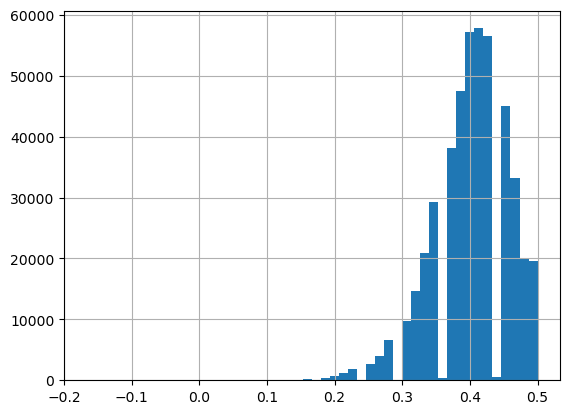

-0.16666666666666669 0.4026711263226761 0.5
    group_std  doc_vol_pdf90      ym_3
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000 -0.000238
3    -σ to +σ       0.011429  0.000103
4   +σ to +2σ       0.092694  0.000030
5  +2σ to +3σ       0.151860  0.000072
6   +3σ to +∞       0.402460  0.000001


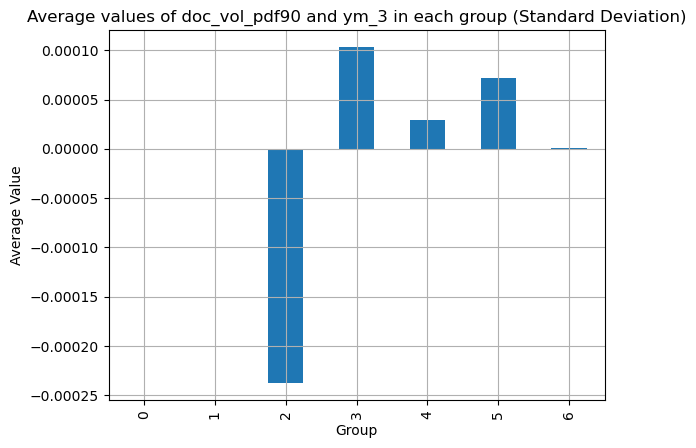

    group_std  doc_vol_pdf90      ym_3
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000 -0.000238
3    -σ to +σ       0.011429  0.000103
4   +σ to +2σ       0.092694  0.000030
5  +2σ to +3σ       0.151860  0.000072
6   +3σ to +∞       0.402460  0.000001


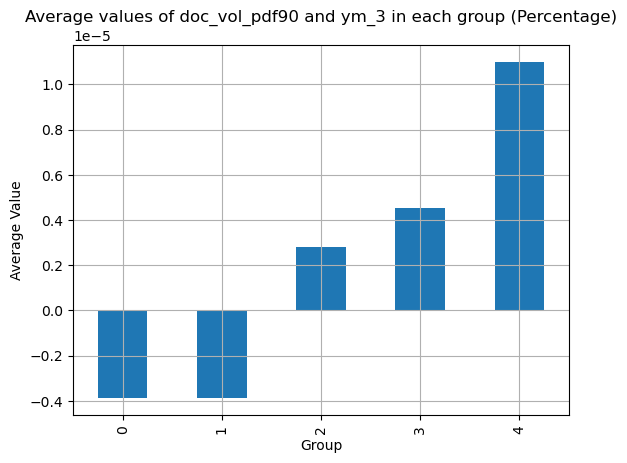

  group_percent  doc_vol_pdf90      ym_3
0         0-20%       0.328135 -0.000004
1        20-40%       0.388052 -0.000004
2        40-60%       0.417000  0.000003
3        60-80%       0.444188  0.000005
4       80-100%       0.477855  0.000011
    group_std  doc_vol_pdf90          ym_5
0   -∞ to -3σ            NaN           NaN
1  -3σ to -2σ            NaN           NaN
2   -2σ to -σ      -0.100000  2.376708e-04
3    -σ to +σ       0.011429  1.869466e-04
4   +σ to +2σ       0.092694  2.861099e-05
5  +2σ to +3σ       0.151860  1.305157e-04
6   +3σ to +∞       0.402460  8.167944e-07


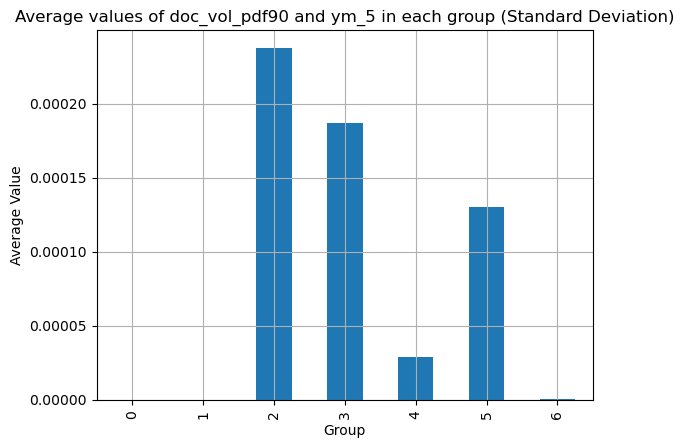

    group_std  doc_vol_pdf90          ym_5
0   -∞ to -3σ            NaN           NaN
1  -3σ to -2σ            NaN           NaN
2   -2σ to -σ      -0.100000  2.376708e-04
3    -σ to +σ       0.011429  1.869466e-04
4   +σ to +2σ       0.092694  2.861099e-05
5  +2σ to +3σ       0.151860  1.305157e-04
6   +3σ to +∞       0.402460  8.167944e-07


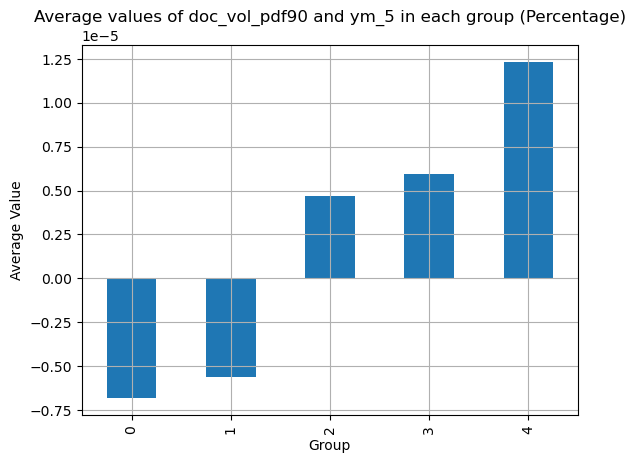

  group_percent  doc_vol_pdf90      ym_5
0         0-20%       0.328135 -0.000007
1        20-40%       0.388052 -0.000006
2        40-60%       0.417000  0.000005
3        60-80%       0.444188  0.000006
4       80-100%       0.477855  0.000012


In [20]:
# test
assess_doc_vol_pdf_percent(data_extract, 60, 90, ['ym_3', 'ym_5'])

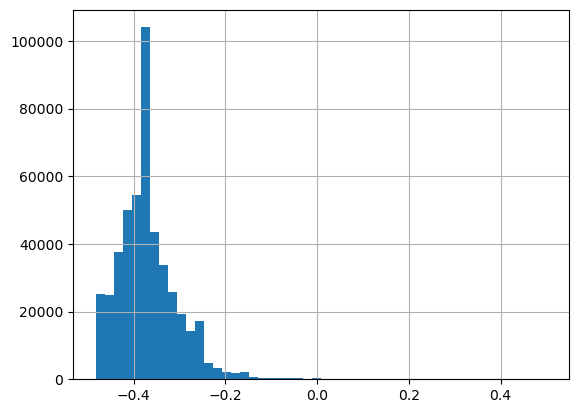

-0.48333333333333334 -0.36998587381059317 0.5
    group_std  doc_vol_pdf10          ym_3
0   -∞ to -3σ      -0.377259  5.914349e-07
1  -3σ to -2σ      -0.212602  1.977185e-05
2   -2σ to -σ      -0.126916  2.515456e-05
3    -σ to +σ      -0.023637  2.399618e-05
4   +σ to +2σ       0.110606  1.704609e-05
5  +2σ to +3σ       0.177011  9.396149e-05
6   +3σ to +∞       0.471183  8.812710e-05


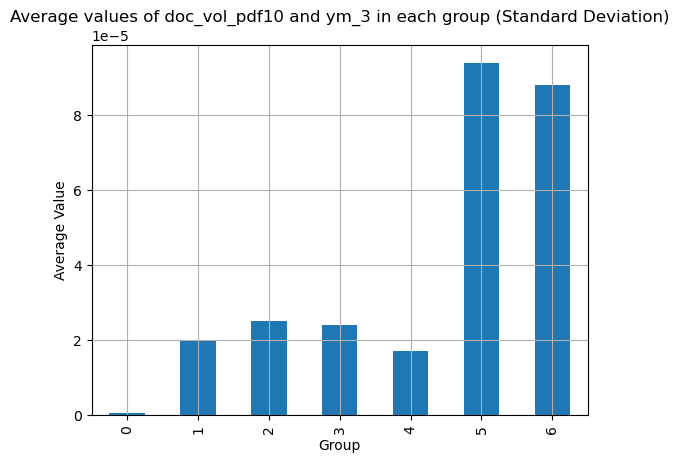

    group_std  doc_vol_pdf10          ym_3
0   -∞ to -3σ      -0.377259  5.914349e-07
1  -3σ to -2σ      -0.212602  1.977185e-05
2   -2σ to -σ      -0.126916  2.515456e-05
3    -σ to +σ      -0.023637  2.399618e-05
4   +σ to +2σ       0.110606  1.704609e-05
5  +2σ to +3σ       0.177011  9.396149e-05
6   +3σ to +∞       0.471183  8.812710e-05


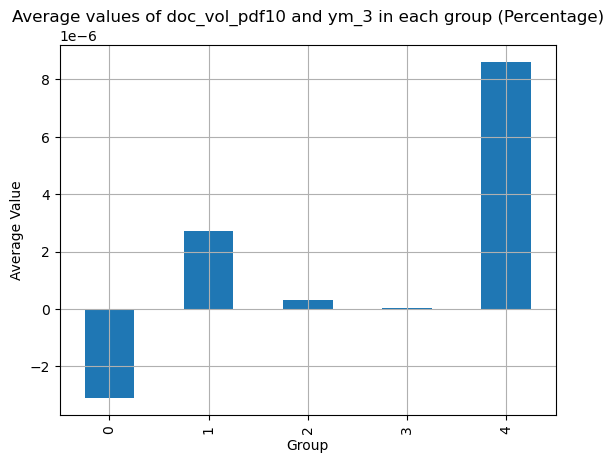

  group_percent  doc_vol_pdf10          ym_3
0         0-20%      -0.437092 -3.099706e-06
1        20-40%      -0.399510  2.732721e-06
2        40-60%      -0.370630  3.181604e-07
3        60-80%      -0.338851  4.006786e-08
4       80-100%      -0.268365  8.602652e-06
    group_std  doc_vol_pdf10          ym_5
0   -∞ to -3σ      -0.377259  5.293223e-08
1  -3σ to -2σ      -0.212602  3.081468e-05
2   -2σ to -σ      -0.126916  2.783286e-05
3    -σ to +σ      -0.023637  3.077252e-05
4   +σ to +2σ       0.110606 -5.467443e-05
5  +2σ to +3σ       0.177011  3.721501e-04
6   +3σ to +∞       0.471183  1.578291e-05


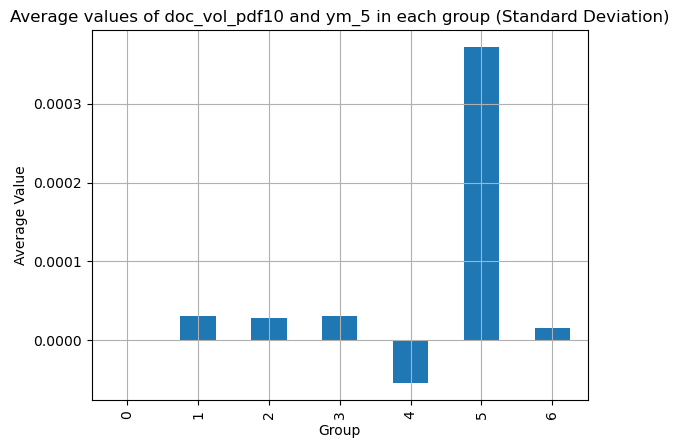

    group_std  doc_vol_pdf10          ym_5
0   -∞ to -3σ      -0.377259  5.293223e-08
1  -3σ to -2σ      -0.212602  3.081468e-05
2   -2σ to -σ      -0.126916  2.783286e-05
3    -σ to +σ      -0.023637  3.077252e-05
4   +σ to +2σ       0.110606 -5.467443e-05
5  +2σ to +3σ       0.177011  3.721501e-04
6   +3σ to +∞       0.471183  1.578291e-05


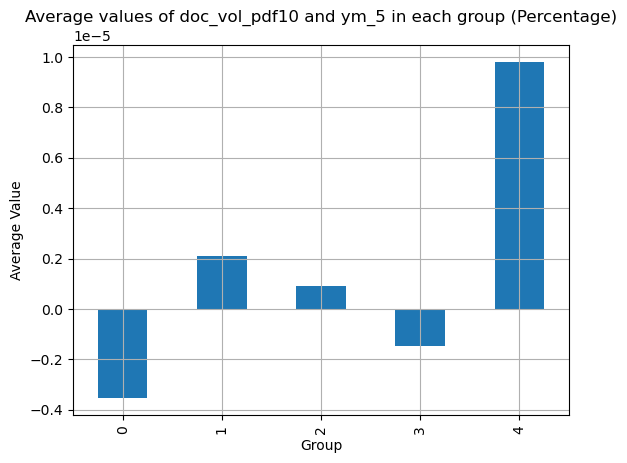

  group_percent  doc_vol_pdf10          ym_5
0         0-20%      -0.437092 -3.538027e-06
1        20-40%      -0.399510  2.082188e-06
2        40-60%      -0.370630  9.156933e-07
3        60-80%      -0.338851 -1.466839e-06
4       80-100%      -0.268365  9.797931e-06
    group_std  doc_vol_pdf10     ym_10
0   -∞ to -3σ      -0.377259 -0.000004
1  -3σ to -2σ      -0.212602  0.000041
2   -2σ to -σ      -0.126916  0.000027
3    -σ to +σ      -0.023637  0.000018
4   +σ to +2σ       0.110606 -0.000095
5  +2σ to +3σ       0.177011  0.000282
6   +3σ to +∞       0.471183 -0.000054


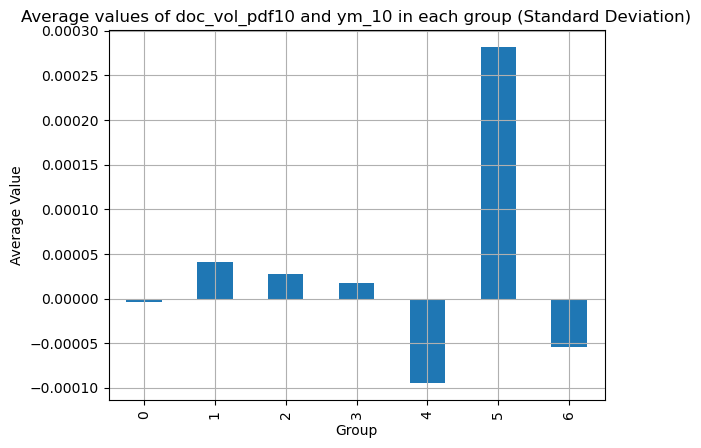

    group_std  doc_vol_pdf10     ym_10
0   -∞ to -3σ      -0.377259 -0.000004
1  -3σ to -2σ      -0.212602  0.000041
2   -2σ to -σ      -0.126916  0.000027
3    -σ to +σ      -0.023637  0.000018
4   +σ to +2σ       0.110606 -0.000095
5  +2σ to +3σ       0.177011  0.000282
6   +3σ to +∞       0.471183 -0.000054


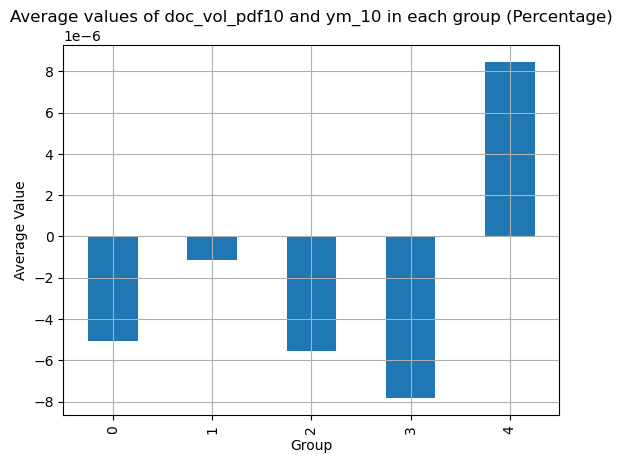

  group_percent  doc_vol_pdf10     ym_10
0         0-20%      -0.437092 -0.000005
1        20-40%      -0.399510 -0.000001
2        40-60%      -0.370630 -0.000006
3        60-80%      -0.338851 -0.000008
4       80-100%      -0.268365  0.000008
    group_std  doc_vol_pdf10    y_1min
0   -∞ to -3σ      -0.377259  0.000005
1  -3σ to -2σ      -0.212602  0.000115
2   -2σ to -σ      -0.126916  0.000077
3    -σ to +σ      -0.023637  0.000054
4   +σ to +2σ       0.110606  0.000250
5  +2σ to +3σ       0.177011  0.000758
6   +3σ to +∞       0.471183 -0.000005


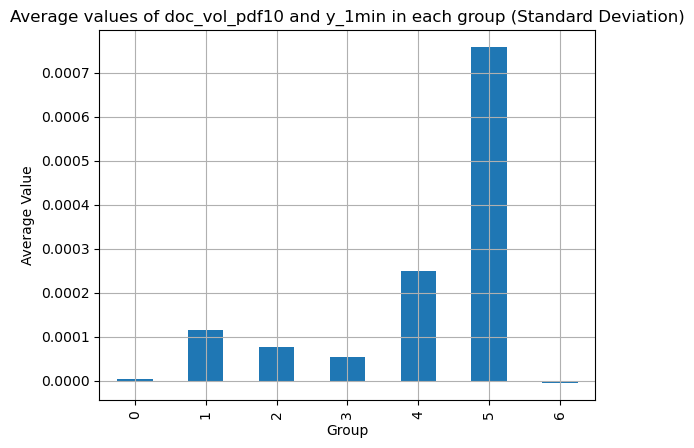

    group_std  doc_vol_pdf10    y_1min
0   -∞ to -3σ      -0.377259  0.000005
1  -3σ to -2σ      -0.212602  0.000115
2   -2σ to -σ      -0.126916  0.000077
3    -σ to +σ      -0.023637  0.000054
4   +σ to +2σ       0.110606  0.000250
5  +2σ to +3σ       0.177011  0.000758
6   +3σ to +∞       0.471183 -0.000005


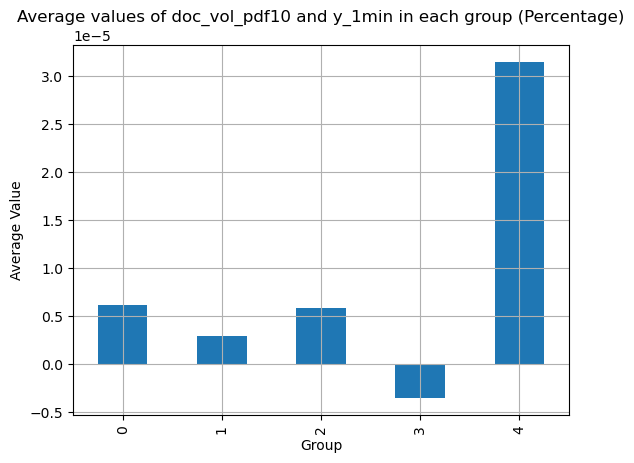

  group_percent  doc_vol_pdf10    y_1min
0         0-20%      -0.437092  0.000006
1        20-40%      -0.399510  0.000003
2        40-60%      -0.370630  0.000006
3        60-80%      -0.338851 -0.000004
4       80-100%      -0.268365  0.000031
    group_std  doc_vol_pdf10    y_3min
0   -∞ to -3σ      -0.377259  0.000018
1  -3σ to -2σ      -0.212602  0.000224
2   -2σ to -σ      -0.126916  0.000329
3    -σ to +σ      -0.023637  0.000110
4   +σ to +2σ       0.110606  0.000706
5  +2σ to +3σ       0.177011  0.001404
6   +3σ to +∞       0.471183  0.000320


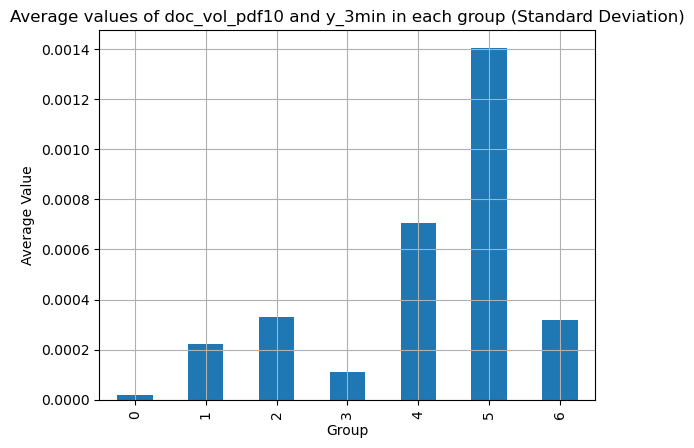

    group_std  doc_vol_pdf10    y_3min
0   -∞ to -3σ      -0.377259  0.000018
1  -3σ to -2σ      -0.212602  0.000224
2   -2σ to -σ      -0.126916  0.000329
3    -σ to +σ      -0.023637  0.000110
4   +σ to +2σ       0.110606  0.000706
5  +2σ to +3σ       0.177011  0.001404
6   +3σ to +∞       0.471183  0.000320


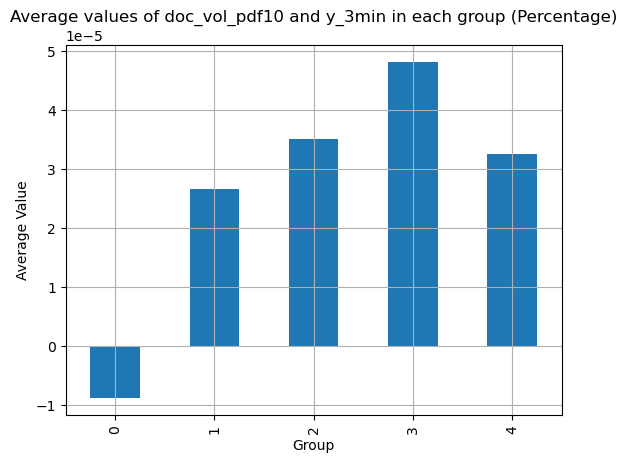

  group_percent  doc_vol_pdf10    y_3min
0         0-20%      -0.437092 -0.000009
1        20-40%      -0.399510  0.000027
2        40-60%      -0.370630  0.000035
3        60-80%      -0.338851  0.000048
4       80-100%      -0.268365  0.000033


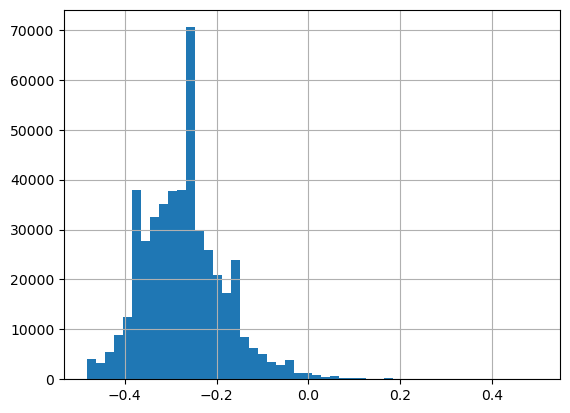

-0.48333333333333334 -0.2716094848700327 0.5
    group_std  doc_vol_pdf20          ym_3
0   -∞ to -3σ      -0.332228 -1.474974e-06
1  -3σ to -2σ      -0.238990  5.064682e-07
2   -2σ to -σ      -0.157259  6.356762e-06
3    -σ to +σ      -0.042087  3.170471e-05
4   +σ to +2σ       0.135836  1.857923e-05
5  +2σ to +3σ       0.218335  8.395161e-05
6   +3σ to +∞       0.452640  5.797651e-05


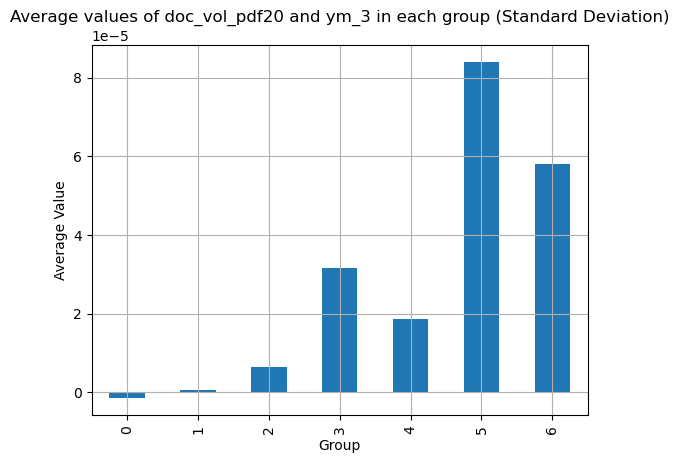

    group_std  doc_vol_pdf20          ym_3
0   -∞ to -3σ      -0.332228 -1.474974e-06
1  -3σ to -2σ      -0.238990  5.064682e-07
2   -2σ to -σ      -0.157259  6.356762e-06
3    -σ to +σ      -0.042087  3.170471e-05
4   +σ to +2σ       0.135836  1.857923e-05
5  +2σ to +3σ       0.218335  8.395161e-05
6   +3σ to +∞       0.452640  5.797651e-05


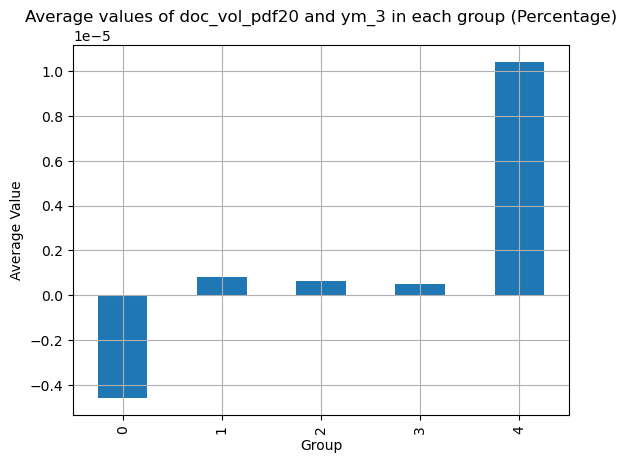

  group_percent  doc_vol_pdf20          ym_3
0         0-20%      -0.379096 -4.585325e-06
1        20-40%      -0.313886  8.163116e-07
2        40-60%      -0.270572  6.402473e-07
3        60-80%      -0.224134  5.177591e-07
4       80-100%      -0.134661  1.040513e-05
    group_std  doc_vol_pdf20      ym_5
0   -∞ to -3σ      -0.332228 -0.000003
1  -3σ to -2σ      -0.238990 -0.000001
2   -2σ to -σ      -0.157259  0.000009
3    -σ to +σ      -0.042087  0.000049
4   +σ to +2σ       0.135836 -0.000001
5  +2σ to +3σ       0.218335  0.000115
6   +3σ to +∞       0.452640  0.000017


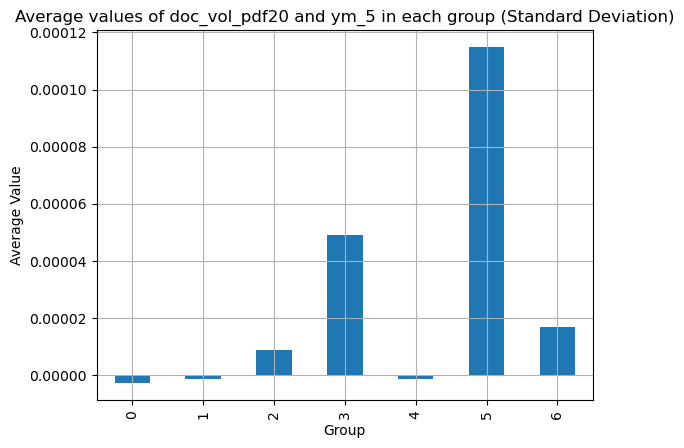

    group_std  doc_vol_pdf20      ym_5
0   -∞ to -3σ      -0.332228 -0.000003
1  -3σ to -2σ      -0.238990 -0.000001
2   -2σ to -σ      -0.157259  0.000009
3    -σ to +σ      -0.042087  0.000049
4   +σ to +2σ       0.135836 -0.000001
5  +2σ to +3σ       0.218335  0.000115
6   +3σ to +∞       0.452640  0.000017


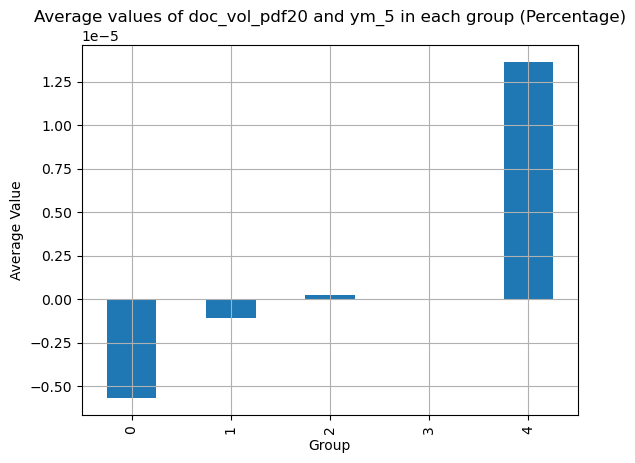

  group_percent  doc_vol_pdf20          ym_5
0         0-20%      -0.379096 -5.689167e-06
1        20-40%      -0.313886 -1.092233e-06
2        40-60%      -0.270572  2.131967e-07
3        60-80%      -0.224134 -6.120118e-08
4       80-100%      -0.134661  1.362531e-05
    group_std  doc_vol_pdf20     ym_10
0   -∞ to -3σ      -0.332228 -0.000007
1  -3σ to -2σ      -0.238990 -0.000007
2   -2σ to -σ      -0.157259  0.000007
3    -σ to +σ      -0.042087  0.000071
4   +σ to +2σ       0.135836  0.000017
5  +2σ to +3σ       0.218335 -0.000126
6   +3σ to +∞       0.452640 -0.000050


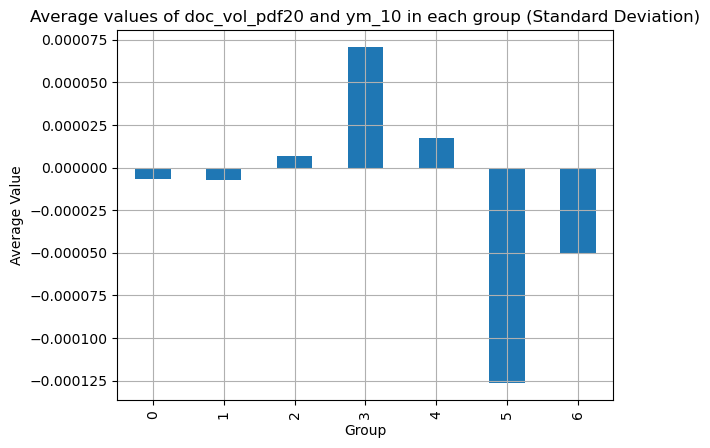

    group_std  doc_vol_pdf20     ym_10
0   -∞ to -3σ      -0.332228 -0.000007
1  -3σ to -2σ      -0.238990 -0.000007
2   -2σ to -σ      -0.157259  0.000007
3    -σ to +σ      -0.042087  0.000071
4   +σ to +2σ       0.135836  0.000017
5  +2σ to +3σ       0.218335 -0.000126
6   +3σ to +∞       0.452640 -0.000050


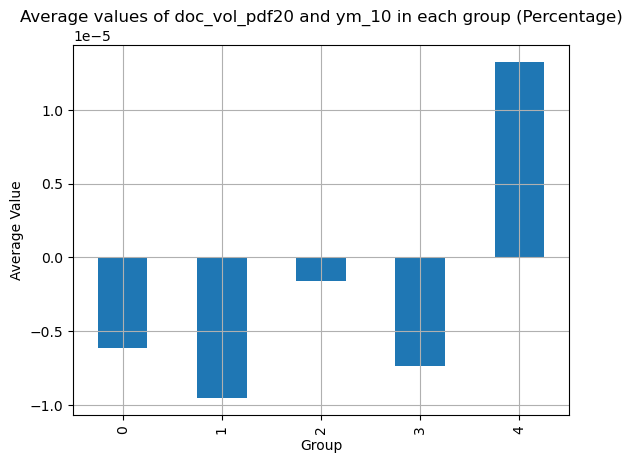

  group_percent  doc_vol_pdf20     ym_10
0         0-20%      -0.379096 -0.000006
1        20-40%      -0.313886 -0.000010
2        40-60%      -0.270572 -0.000002
3        60-80%      -0.224134 -0.000007
4       80-100%      -0.134661  0.000013
    group_std  doc_vol_pdf20        y_1min
0   -∞ to -3σ      -0.332228 -1.001792e-06
1  -3σ to -2σ      -0.238990  5.496308e-08
2   -2σ to -σ      -0.157259  2.627541e-05
3    -σ to +σ      -0.042087  1.501567e-04
4   +σ to +2σ       0.135836  9.062822e-05
5  +2σ to +3σ       0.218335  2.163632e-04
6   +3σ to +∞       0.452640 -6.785786e-05


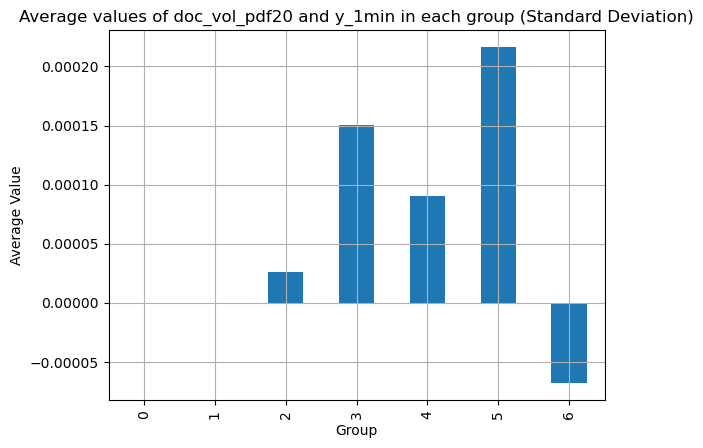

    group_std  doc_vol_pdf20        y_1min
0   -∞ to -3σ      -0.332228 -1.001792e-06
1  -3σ to -2σ      -0.238990  5.496308e-08
2   -2σ to -σ      -0.157259  2.627541e-05
3    -σ to +σ      -0.042087  1.501567e-04
4   +σ to +2σ       0.135836  9.062822e-05
5  +2σ to +3σ       0.218335  2.163632e-04
6   +3σ to +∞       0.452640 -6.785786e-05


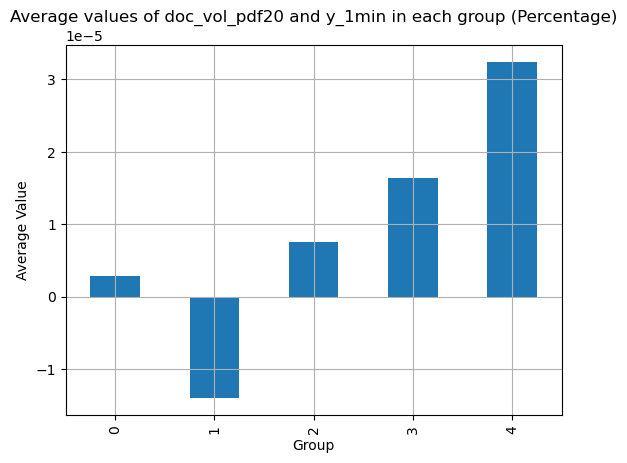

  group_percent  doc_vol_pdf20    y_1min
0         0-20%      -0.379096  0.000003
1        20-40%      -0.313886 -0.000014
2        40-60%      -0.270572  0.000008
3        60-80%      -0.224134  0.000016
4       80-100%      -0.134661  0.000032
    group_std  doc_vol_pdf20    y_3min
0   -∞ to -3σ      -0.332228  0.000012
1  -3σ to -2σ      -0.238990  0.000009
2   -2σ to -σ      -0.157259  0.000052
3    -σ to +σ      -0.042087  0.000259
4   +σ to +2σ       0.135836  0.000300
5  +2σ to +3σ       0.218335 -0.000263
6   +3σ to +∞       0.452640  0.000215


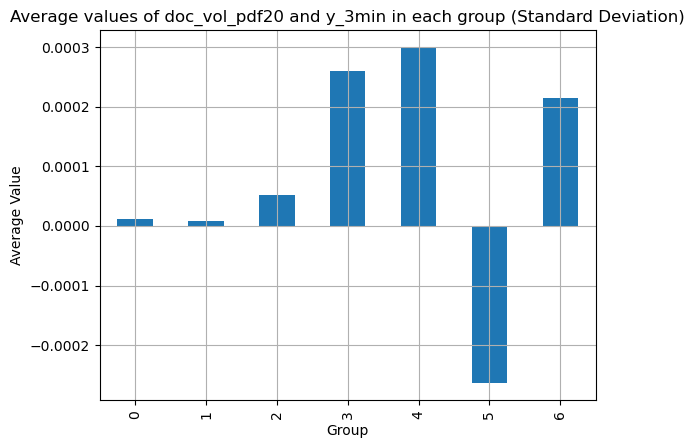

    group_std  doc_vol_pdf20    y_3min
0   -∞ to -3σ      -0.332228  0.000012
1  -3σ to -2σ      -0.238990  0.000009
2   -2σ to -σ      -0.157259  0.000052
3    -σ to +σ      -0.042087  0.000259
4   +σ to +2σ       0.135836  0.000300
5  +2σ to +3σ       0.218335 -0.000263
6   +3σ to +∞       0.452640  0.000215


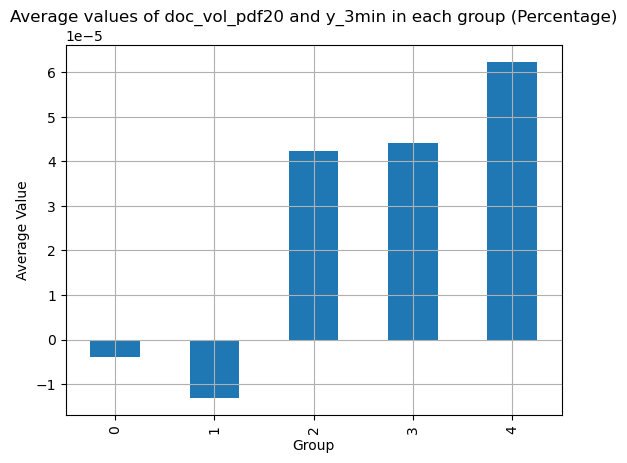

  group_percent  doc_vol_pdf20    y_3min
0         0-20%      -0.379096 -0.000004
1        20-40%      -0.313886 -0.000013
2        40-60%      -0.270572  0.000042
3        60-80%      -0.224134  0.000044
4       80-100%      -0.134661  0.000062


In [22]:
# 回望 20 分位数 90 
assess_doc_vol_pdf_percent(data_extract, 60, 10, ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min'])

# 回望 20 分位数 80 
assess_doc_vol_pdf_percent(data_extract, 60, 20, ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min'])

# 回望 20 分位数 70

# 回望 60 分位数 10 

# 回望 60 分位数 20

# 回望 60 分位数 30 

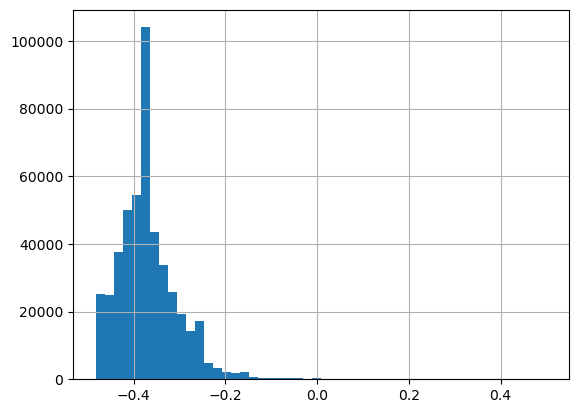

-0.48333333333333334 -0.36998587381059317 0.5
    group_std  doc_vol_pdf10          ym_3
0   -∞ to -3σ      -0.377259  5.914349e-07
1  -3σ to -2σ      -0.212602  1.977185e-05
2   -2σ to -σ      -0.126916  2.515456e-05
3    -σ to +σ      -0.023637  2.399618e-05
4   +σ to +2σ       0.110606  1.704609e-05
5  +2σ to +3σ       0.177011  9.396149e-05
6   +3σ to +∞       0.471183  8.812710e-05


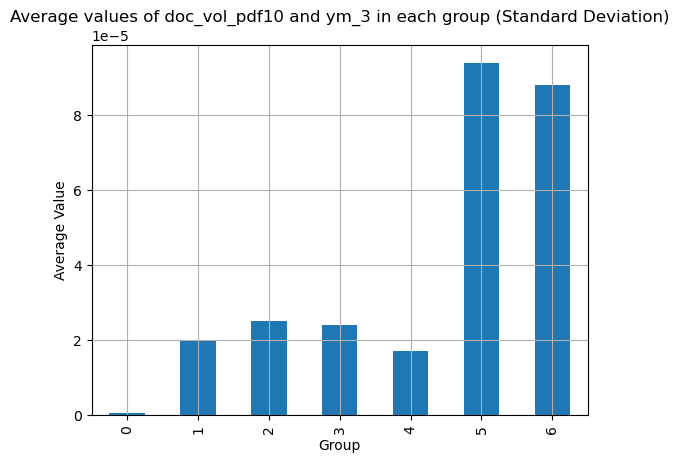

    group_std  doc_vol_pdf10          ym_3
0   -∞ to -3σ      -0.377259  5.914349e-07
1  -3σ to -2σ      -0.212602  1.977185e-05
2   -2σ to -σ      -0.126916  2.515456e-05
3    -σ to +σ      -0.023637  2.399618e-05
4   +σ to +2σ       0.110606  1.704609e-05
5  +2σ to +3σ       0.177011  9.396149e-05
6   +3σ to +∞       0.471183  8.812710e-05


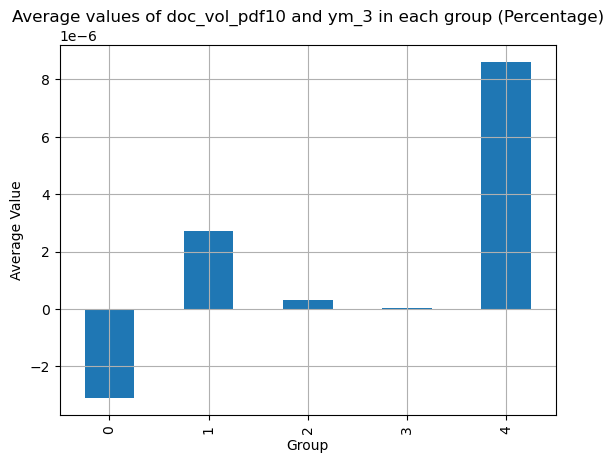

  group_percent  doc_vol_pdf10          ym_3
0         0-20%      -0.437092 -3.099706e-06
1        20-40%      -0.399510  2.732721e-06
2        40-60%      -0.370630  3.181604e-07
3        60-80%      -0.338851  4.006786e-08
4       80-100%      -0.268365  8.602652e-06
    group_std  doc_vol_pdf10          ym_5
0   -∞ to -3σ      -0.377259  5.293223e-08
1  -3σ to -2σ      -0.212602  3.081468e-05
2   -2σ to -σ      -0.126916  2.783286e-05
3    -σ to +σ      -0.023637  3.077252e-05
4   +σ to +2σ       0.110606 -5.467443e-05
5  +2σ to +3σ       0.177011  3.721501e-04
6   +3σ to +∞       0.471183  1.578291e-05


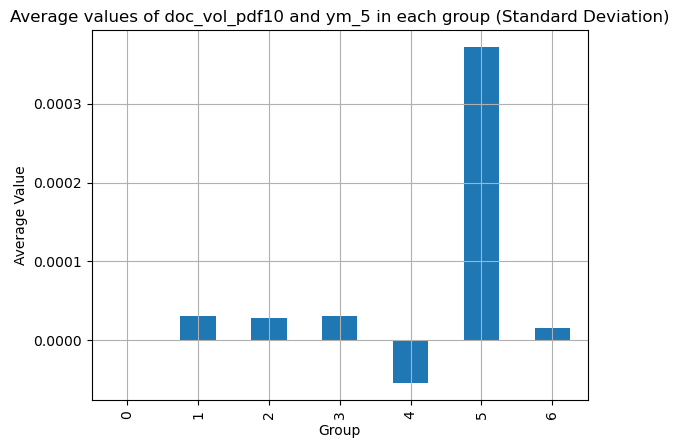

    group_std  doc_vol_pdf10          ym_5
0   -∞ to -3σ      -0.377259  5.293223e-08
1  -3σ to -2σ      -0.212602  3.081468e-05
2   -2σ to -σ      -0.126916  2.783286e-05
3    -σ to +σ      -0.023637  3.077252e-05
4   +σ to +2σ       0.110606 -5.467443e-05
5  +2σ to +3σ       0.177011  3.721501e-04
6   +3σ to +∞       0.471183  1.578291e-05


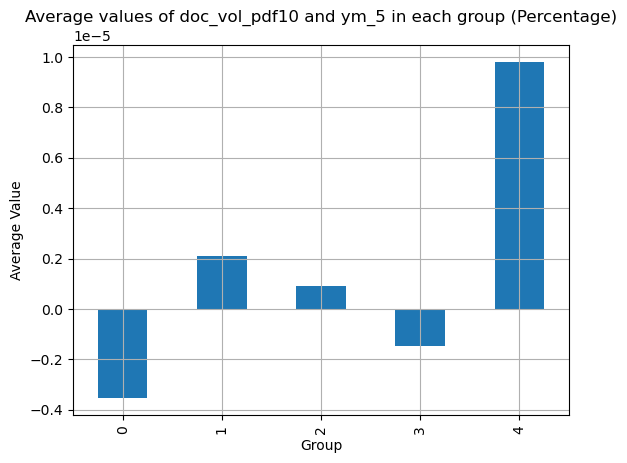

  group_percent  doc_vol_pdf10          ym_5
0         0-20%      -0.437092 -3.538027e-06
1        20-40%      -0.399510  2.082188e-06
2        40-60%      -0.370630  9.156933e-07
3        60-80%      -0.338851 -1.466839e-06
4       80-100%      -0.268365  9.797931e-06
    group_std  doc_vol_pdf10     ym_10
0   -∞ to -3σ      -0.377259 -0.000004
1  -3σ to -2σ      -0.212602  0.000041
2   -2σ to -σ      -0.126916  0.000027
3    -σ to +σ      -0.023637  0.000018
4   +σ to +2σ       0.110606 -0.000095
5  +2σ to +3σ       0.177011  0.000282
6   +3σ to +∞       0.471183 -0.000054


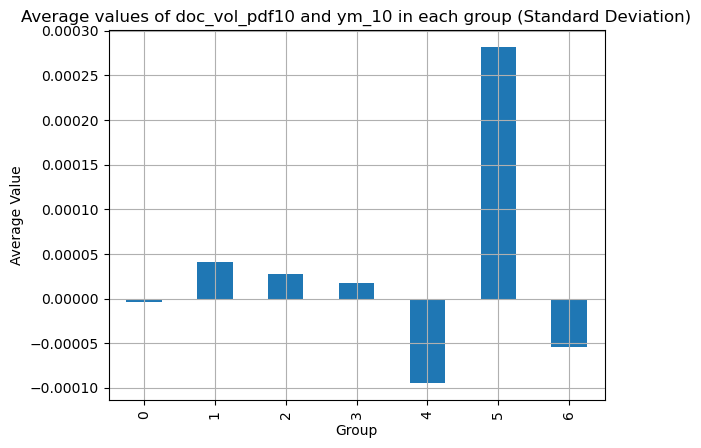

    group_std  doc_vol_pdf10     ym_10
0   -∞ to -3σ      -0.377259 -0.000004
1  -3σ to -2σ      -0.212602  0.000041
2   -2σ to -σ      -0.126916  0.000027
3    -σ to +σ      -0.023637  0.000018
4   +σ to +2σ       0.110606 -0.000095
5  +2σ to +3σ       0.177011  0.000282
6   +3σ to +∞       0.471183 -0.000054


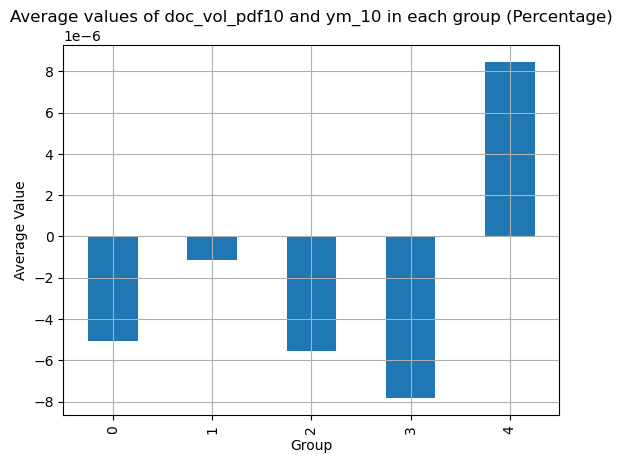

  group_percent  doc_vol_pdf10     ym_10
0         0-20%      -0.437092 -0.000005
1        20-40%      -0.399510 -0.000001
2        40-60%      -0.370630 -0.000006
3        60-80%      -0.338851 -0.000008
4       80-100%      -0.268365  0.000008
    group_std  doc_vol_pdf10    y_1min
0   -∞ to -3σ      -0.377259  0.000005
1  -3σ to -2σ      -0.212602  0.000115
2   -2σ to -σ      -0.126916  0.000077
3    -σ to +σ      -0.023637  0.000054
4   +σ to +2σ       0.110606  0.000250
5  +2σ to +3σ       0.177011  0.000758
6   +3σ to +∞       0.471183 -0.000005


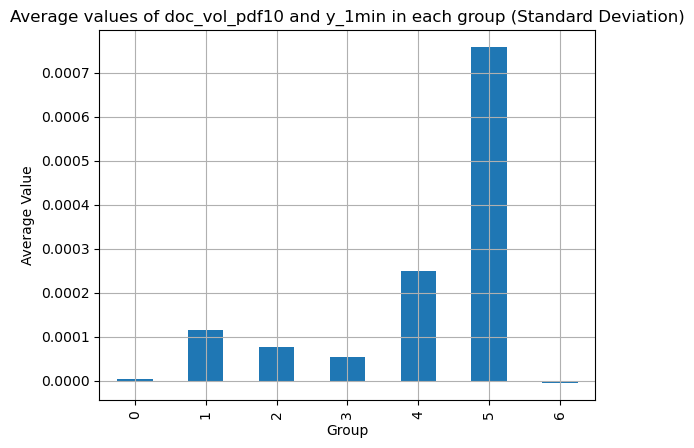

    group_std  doc_vol_pdf10    y_1min
0   -∞ to -3σ      -0.377259  0.000005
1  -3σ to -2σ      -0.212602  0.000115
2   -2σ to -σ      -0.126916  0.000077
3    -σ to +σ      -0.023637  0.000054
4   +σ to +2σ       0.110606  0.000250
5  +2σ to +3σ       0.177011  0.000758
6   +3σ to +∞       0.471183 -0.000005


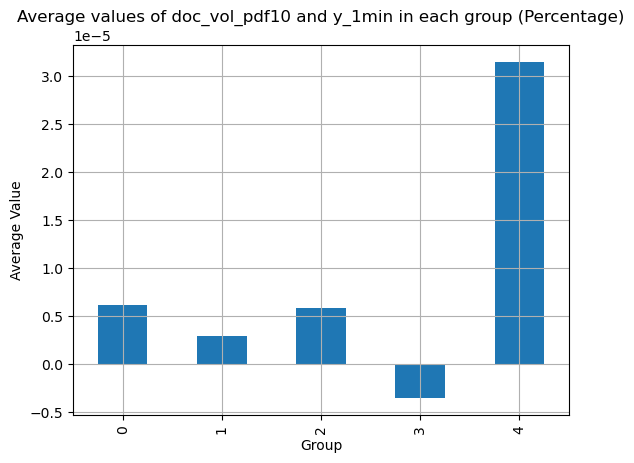

  group_percent  doc_vol_pdf10    y_1min
0         0-20%      -0.437092  0.000006
1        20-40%      -0.399510  0.000003
2        40-60%      -0.370630  0.000006
3        60-80%      -0.338851 -0.000004
4       80-100%      -0.268365  0.000031
    group_std  doc_vol_pdf10    y_3min
0   -∞ to -3σ      -0.377259  0.000018
1  -3σ to -2σ      -0.212602  0.000224
2   -2σ to -σ      -0.126916  0.000329
3    -σ to +σ      -0.023637  0.000110
4   +σ to +2σ       0.110606  0.000706
5  +2σ to +3σ       0.177011  0.001404
6   +3σ to +∞       0.471183  0.000320


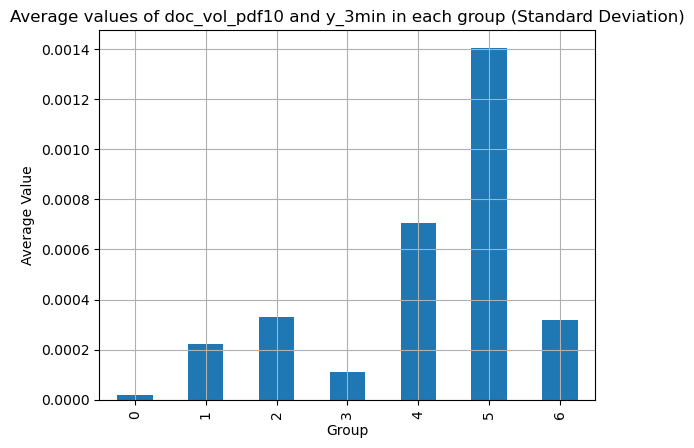

    group_std  doc_vol_pdf10    y_3min
0   -∞ to -3σ      -0.377259  0.000018
1  -3σ to -2σ      -0.212602  0.000224
2   -2σ to -σ      -0.126916  0.000329
3    -σ to +σ      -0.023637  0.000110
4   +σ to +2σ       0.110606  0.000706
5  +2σ to +3σ       0.177011  0.001404
6   +3σ to +∞       0.471183  0.000320


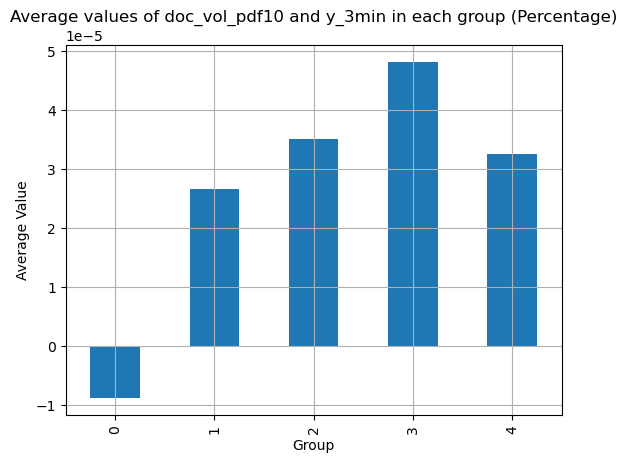

  group_percent  doc_vol_pdf10    y_3min
0         0-20%      -0.437092 -0.000009
1        20-40%      -0.399510  0.000027
2        40-60%      -0.370630  0.000035
3        60-80%      -0.338851  0.000048
4       80-100%      -0.268365  0.000033


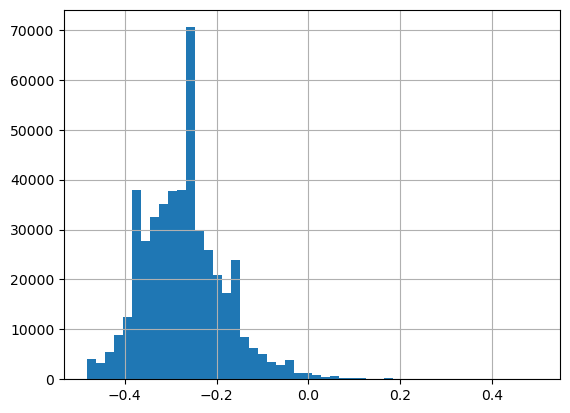

-0.48333333333333334 -0.2716094848700327 0.5
    group_std  doc_vol_pdf20          ym_3
0   -∞ to -3σ      -0.332228 -1.474974e-06
1  -3σ to -2σ      -0.238990  5.064682e-07
2   -2σ to -σ      -0.157259  6.356762e-06
3    -σ to +σ      -0.042087  3.170471e-05
4   +σ to +2σ       0.135836  1.857923e-05
5  +2σ to +3σ       0.218335  8.395161e-05
6   +3σ to +∞       0.452640  5.797651e-05


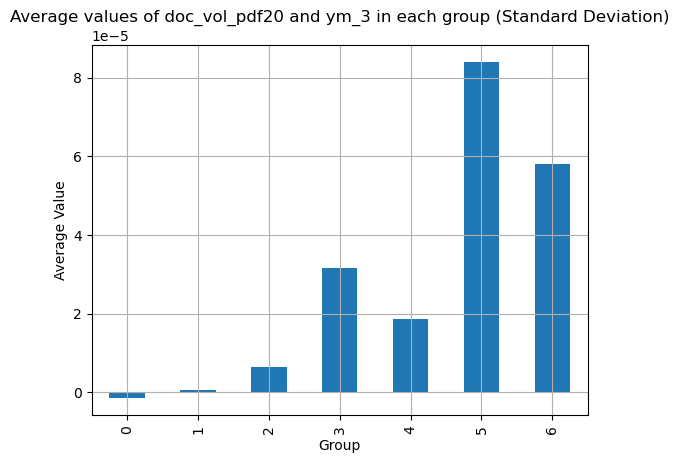

    group_std  doc_vol_pdf20          ym_3
0   -∞ to -3σ      -0.332228 -1.474974e-06
1  -3σ to -2σ      -0.238990  5.064682e-07
2   -2σ to -σ      -0.157259  6.356762e-06
3    -σ to +σ      -0.042087  3.170471e-05
4   +σ to +2σ       0.135836  1.857923e-05
5  +2σ to +3σ       0.218335  8.395161e-05
6   +3σ to +∞       0.452640  5.797651e-05


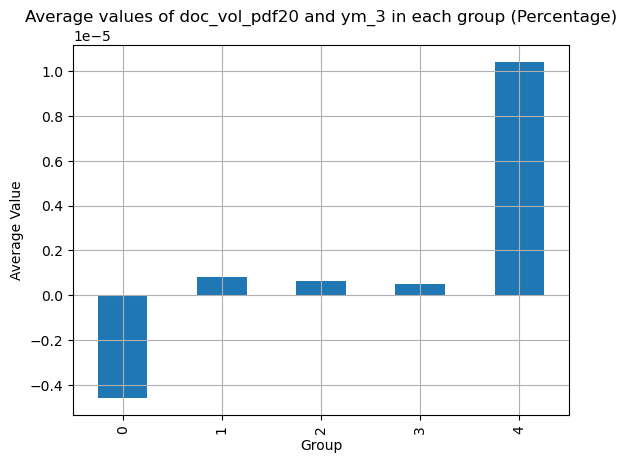

  group_percent  doc_vol_pdf20          ym_3
0         0-20%      -0.379096 -4.585325e-06
1        20-40%      -0.313886  8.163116e-07
2        40-60%      -0.270572  6.402473e-07
3        60-80%      -0.224134  5.177591e-07
4       80-100%      -0.134661  1.040513e-05
    group_std  doc_vol_pdf20      ym_5
0   -∞ to -3σ      -0.332228 -0.000003
1  -3σ to -2σ      -0.238990 -0.000001
2   -2σ to -σ      -0.157259  0.000009
3    -σ to +σ      -0.042087  0.000049
4   +σ to +2σ       0.135836 -0.000001
5  +2σ to +3σ       0.218335  0.000115
6   +3σ to +∞       0.452640  0.000017


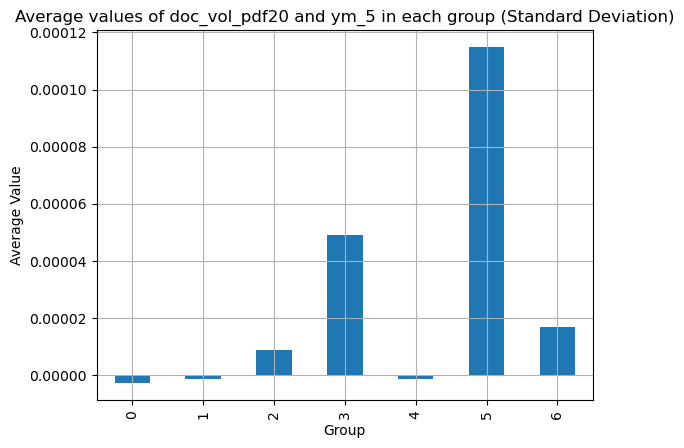

    group_std  doc_vol_pdf20      ym_5
0   -∞ to -3σ      -0.332228 -0.000003
1  -3σ to -2σ      -0.238990 -0.000001
2   -2σ to -σ      -0.157259  0.000009
3    -σ to +σ      -0.042087  0.000049
4   +σ to +2σ       0.135836 -0.000001
5  +2σ to +3σ       0.218335  0.000115
6   +3σ to +∞       0.452640  0.000017


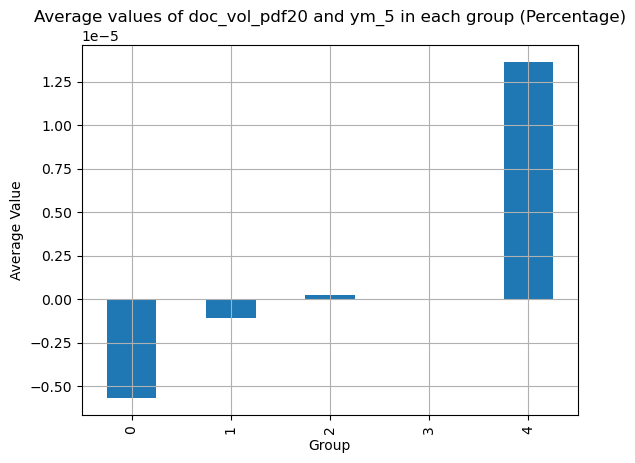

  group_percent  doc_vol_pdf20          ym_5
0         0-20%      -0.379096 -5.689167e-06
1        20-40%      -0.313886 -1.092233e-06
2        40-60%      -0.270572  2.131967e-07
3        60-80%      -0.224134 -6.120118e-08
4       80-100%      -0.134661  1.362531e-05
    group_std  doc_vol_pdf20     ym_10
0   -∞ to -3σ      -0.332228 -0.000007
1  -3σ to -2σ      -0.238990 -0.000007
2   -2σ to -σ      -0.157259  0.000007
3    -σ to +σ      -0.042087  0.000071
4   +σ to +2σ       0.135836  0.000017
5  +2σ to +3σ       0.218335 -0.000126
6   +3σ to +∞       0.452640 -0.000050


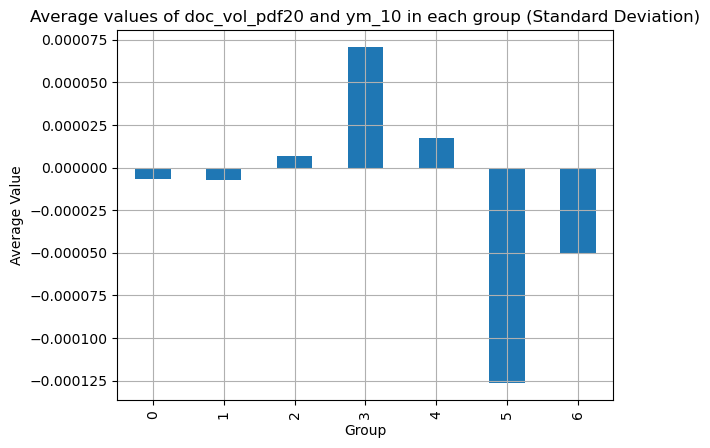

    group_std  doc_vol_pdf20     ym_10
0   -∞ to -3σ      -0.332228 -0.000007
1  -3σ to -2σ      -0.238990 -0.000007
2   -2σ to -σ      -0.157259  0.000007
3    -σ to +σ      -0.042087  0.000071
4   +σ to +2σ       0.135836  0.000017
5  +2σ to +3σ       0.218335 -0.000126
6   +3σ to +∞       0.452640 -0.000050


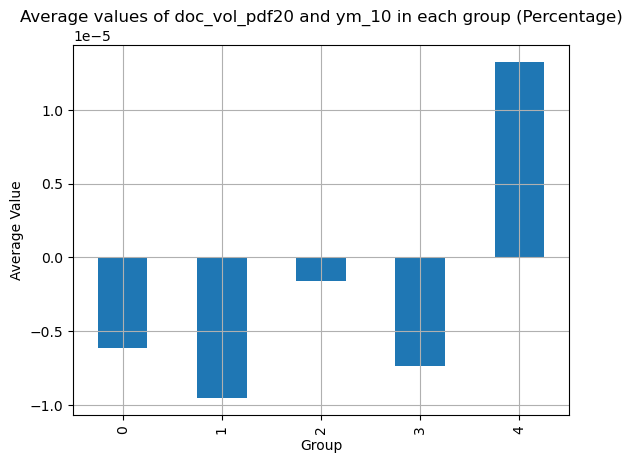

  group_percent  doc_vol_pdf20     ym_10
0         0-20%      -0.379096 -0.000006
1        20-40%      -0.313886 -0.000010
2        40-60%      -0.270572 -0.000002
3        60-80%      -0.224134 -0.000007
4       80-100%      -0.134661  0.000013
    group_std  doc_vol_pdf20        y_1min
0   -∞ to -3σ      -0.332228 -1.001792e-06
1  -3σ to -2σ      -0.238990  5.496308e-08
2   -2σ to -σ      -0.157259  2.627541e-05
3    -σ to +σ      -0.042087  1.501567e-04
4   +σ to +2σ       0.135836  9.062822e-05
5  +2σ to +3σ       0.218335  2.163632e-04
6   +3σ to +∞       0.452640 -6.785786e-05


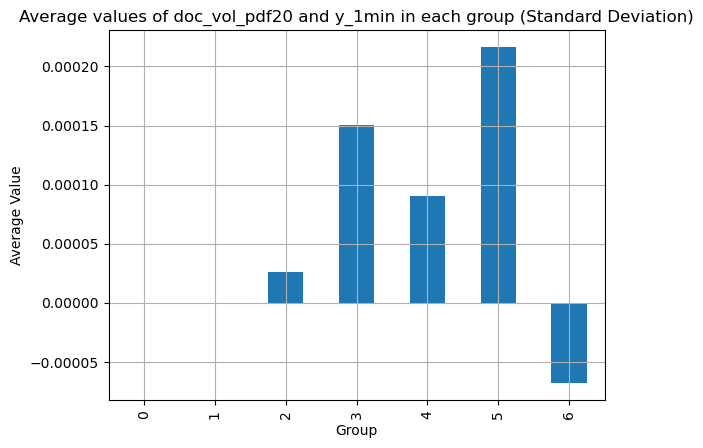

    group_std  doc_vol_pdf20        y_1min
0   -∞ to -3σ      -0.332228 -1.001792e-06
1  -3σ to -2σ      -0.238990  5.496308e-08
2   -2σ to -σ      -0.157259  2.627541e-05
3    -σ to +σ      -0.042087  1.501567e-04
4   +σ to +2σ       0.135836  9.062822e-05
5  +2σ to +3σ       0.218335  2.163632e-04
6   +3σ to +∞       0.452640 -6.785786e-05


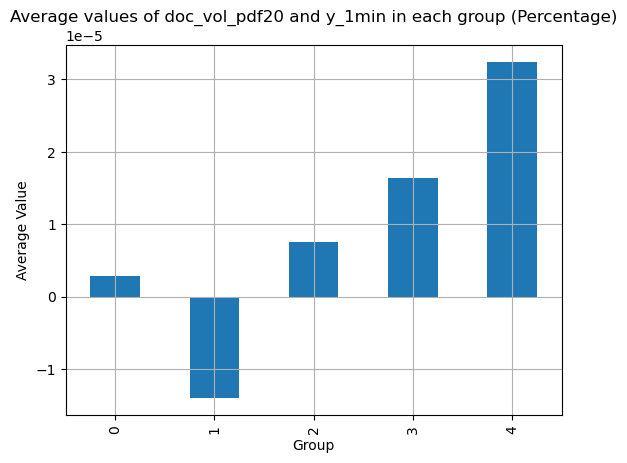

  group_percent  doc_vol_pdf20    y_1min
0         0-20%      -0.379096  0.000003
1        20-40%      -0.313886 -0.000014
2        40-60%      -0.270572  0.000008
3        60-80%      -0.224134  0.000016
4       80-100%      -0.134661  0.000032
    group_std  doc_vol_pdf20    y_3min
0   -∞ to -3σ      -0.332228  0.000012
1  -3σ to -2σ      -0.238990  0.000009
2   -2σ to -σ      -0.157259  0.000052
3    -σ to +σ      -0.042087  0.000259
4   +σ to +2σ       0.135836  0.000300
5  +2σ to +3σ       0.218335 -0.000263
6   +3σ to +∞       0.452640  0.000215


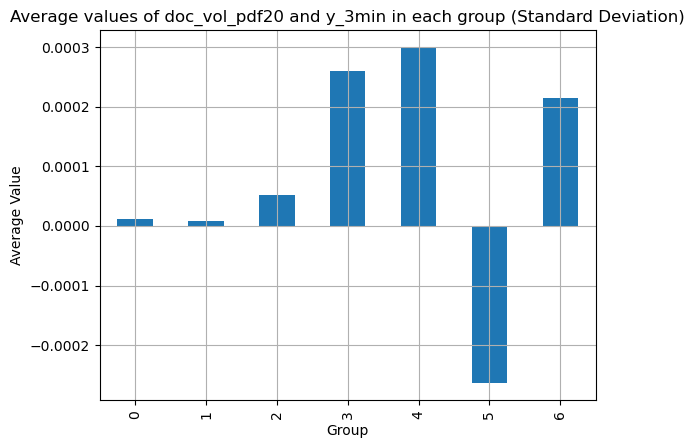

    group_std  doc_vol_pdf20    y_3min
0   -∞ to -3σ      -0.332228  0.000012
1  -3σ to -2σ      -0.238990  0.000009
2   -2σ to -σ      -0.157259  0.000052
3    -σ to +σ      -0.042087  0.000259
4   +σ to +2σ       0.135836  0.000300
5  +2σ to +3σ       0.218335 -0.000263
6   +3σ to +∞       0.452640  0.000215


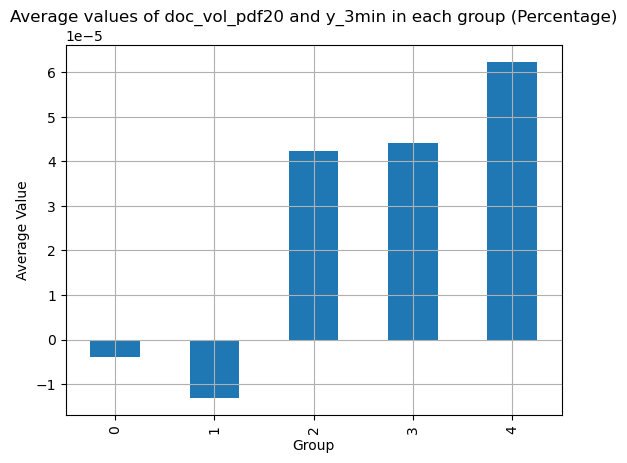

  group_percent  doc_vol_pdf20    y_3min
0         0-20%      -0.379096 -0.000004
1        20-40%      -0.313886 -0.000013
2        40-60%      -0.270572  0.000042
3        60-80%      -0.224134  0.000044
4       80-100%      -0.134661  0.000062


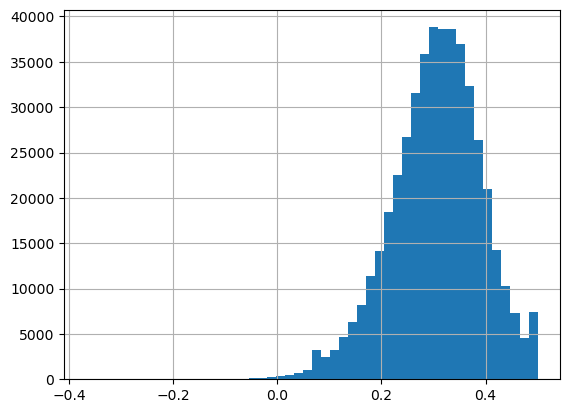

-0.3666666666666667 0.30466864199800636 0.5
    group_std  doc_vol_pdf80          ym_3
0   -∞ to -3σ      -0.316667 -1.994979e-04
1  -3σ to -2σ      -0.232222 -3.506503e-06
2   -2σ to -σ      -0.112907 -3.681583e-05
3    -σ to +σ       0.040457 -3.596423e-07
4   +σ to +2σ       0.138563 -1.425536e-06
5  +2σ to +3σ       0.220782 -3.723952e-06
6   +3σ to +∞       0.339485  2.675146e-06


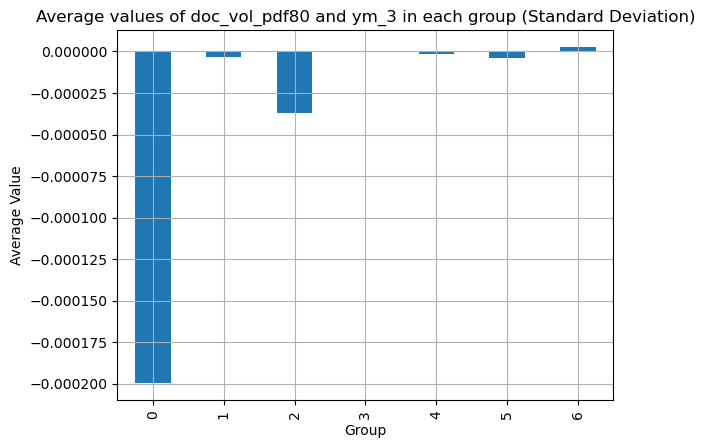

    group_std  doc_vol_pdf80          ym_3
0   -∞ to -3σ      -0.316667 -1.994979e-04
1  -3σ to -2σ      -0.232222 -3.506503e-06
2   -2σ to -σ      -0.112907 -3.681583e-05
3    -σ to +σ       0.040457 -3.596423e-07
4   +σ to +2σ       0.138563 -1.425536e-06
5  +2σ to +3σ       0.220782 -3.723952e-06
6   +3σ to +∞       0.339485  2.675146e-06


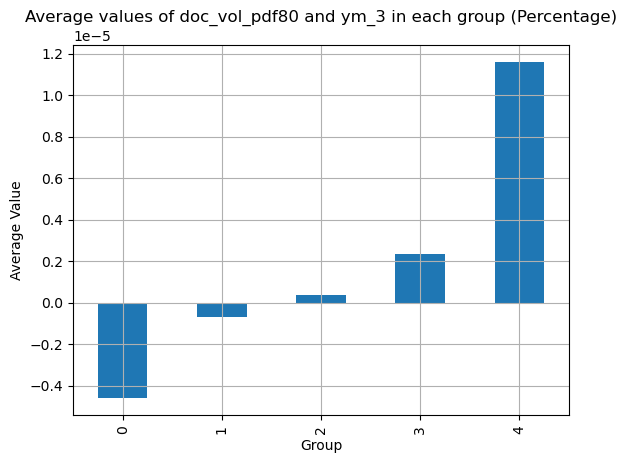

  group_percent  doc_vol_pdf80          ym_3
0         0-20%       0.189938 -4.603510e-06
1        20-40%       0.275476 -7.078355e-07
2        40-60%       0.320808  3.702776e-07
3        60-80%       0.359651  2.347559e-06
4       80-100%       0.417654  1.158906e-05
    group_std  doc_vol_pdf80      ym_5
0   -∞ to -3σ      -0.316667 -0.000333
1  -3σ to -2σ      -0.232222  0.000034
2   -2σ to -σ      -0.112907 -0.000103
3    -σ to +σ       0.040457  0.000004
4   +σ to +2σ       0.138563 -0.000003
5  +2σ to +3σ       0.220782 -0.000007
6   +3σ to +∞       0.339485  0.000003


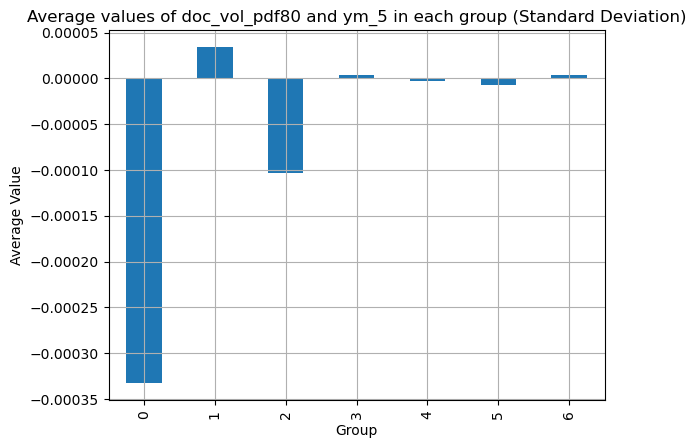

    group_std  doc_vol_pdf80      ym_5
0   -∞ to -3σ      -0.316667 -0.000333
1  -3σ to -2σ      -0.232222  0.000034
2   -2σ to -σ      -0.112907 -0.000103
3    -σ to +σ       0.040457  0.000004
4   +σ to +2σ       0.138563 -0.000003
5  +2σ to +3σ       0.220782 -0.000007
6   +3σ to +∞       0.339485  0.000003


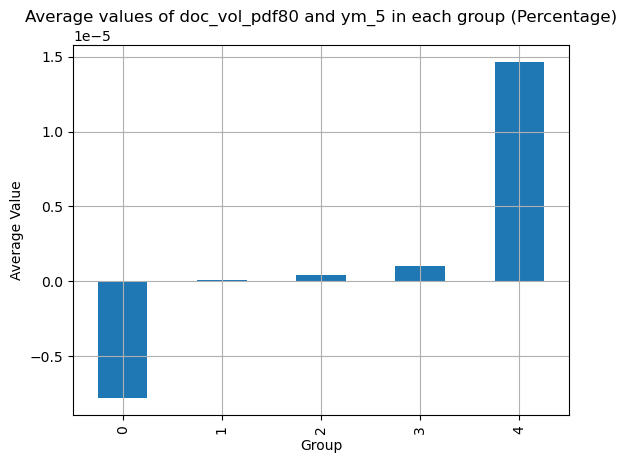

  group_percent  doc_vol_pdf80          ym_5
0         0-20%       0.189938 -7.809133e-06
1        20-40%       0.275476  1.042615e-07
2        40-60%       0.320808  4.317959e-07
3        60-80%       0.359651  1.003282e-06
4       80-100%       0.417654  1.464573e-05
    group_std  doc_vol_pdf80         ym_10
0   -∞ to -3σ      -0.316667 -4.655726e-04
1  -3σ to -2σ      -0.232222  1.951172e-05
2   -2σ to -σ      -0.112907 -1.008130e-04
3    -σ to +σ       0.040457  3.140804e-05
4   +σ to +2σ       0.138563  4.690498e-06
5  +2σ to +3σ       0.220782 -1.400423e-05
6   +3σ to +∞       0.339485 -8.630883e-07


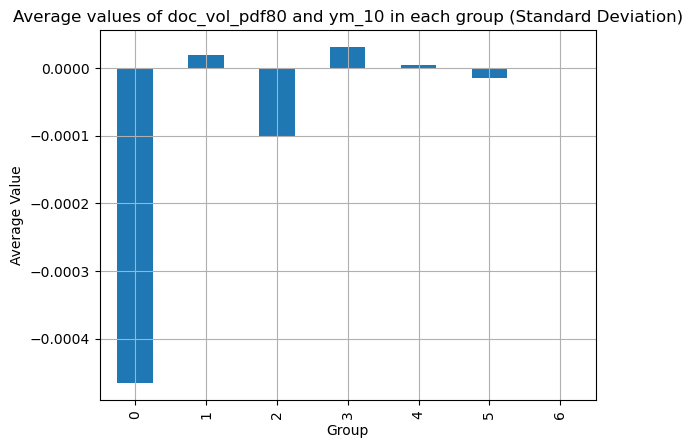

    group_std  doc_vol_pdf80         ym_10
0   -∞ to -3σ      -0.316667 -4.655726e-04
1  -3σ to -2σ      -0.232222  1.951172e-05
2   -2σ to -σ      -0.112907 -1.008130e-04
3    -σ to +σ       0.040457  3.140804e-05
4   +σ to +2σ       0.138563  4.690498e-06
5  +2σ to +3σ       0.220782 -1.400423e-05
6   +3σ to +∞       0.339485 -8.630883e-07


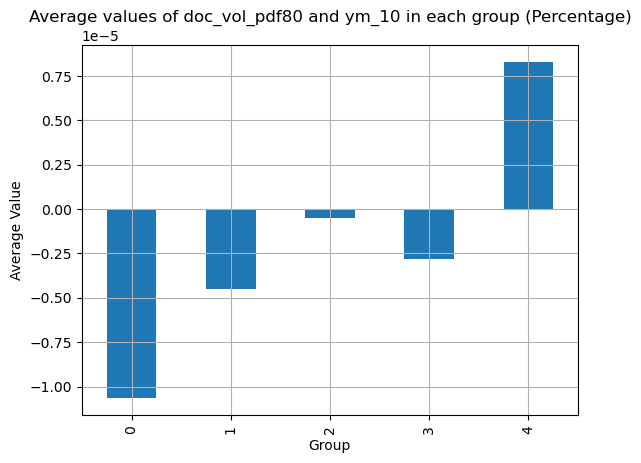

  group_percent  doc_vol_pdf80         ym_10
0         0-20%       0.189938 -1.064875e-05
1        20-40%       0.275476 -4.506065e-06
2        40-60%       0.320808 -4.925363e-07
3        60-80%       0.359651 -2.793951e-06
4       80-100%       0.417654  8.272132e-06
    group_std  doc_vol_pdf80    y_1min
0   -∞ to -3σ      -0.316667 -0.000599
1  -3σ to -2σ      -0.232222  0.000223
2   -2σ to -σ      -0.112907 -0.000070
3    -σ to +σ       0.040457  0.000133
4   +σ to +2σ       0.138563  0.000017
5  +2σ to +3σ       0.220782 -0.000013
6   +3σ to +∞       0.339485  0.000010


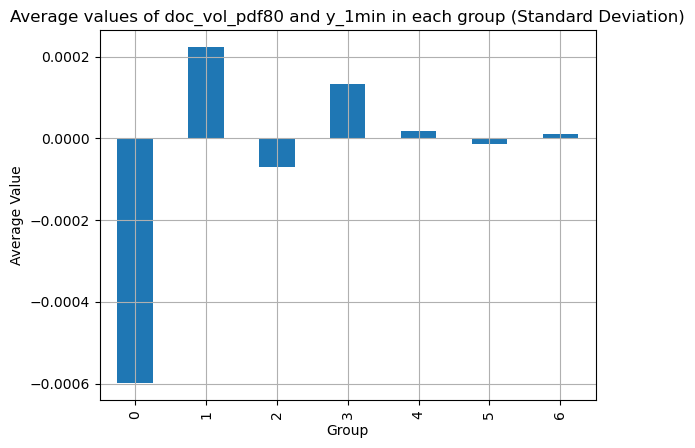

    group_std  doc_vol_pdf80    y_1min
0   -∞ to -3σ      -0.316667 -0.000599
1  -3σ to -2σ      -0.232222  0.000223
2   -2σ to -σ      -0.112907 -0.000070
3    -σ to +σ       0.040457  0.000133
4   +σ to +2σ       0.138563  0.000017
5  +2σ to +3σ       0.220782 -0.000013
6   +3σ to +∞       0.339485  0.000010


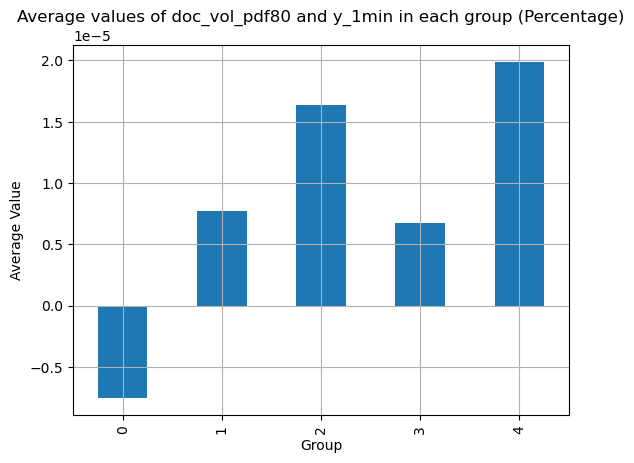

  group_percent  doc_vol_pdf80    y_1min
0         0-20%       0.189938 -0.000008
1        20-40%       0.275476  0.000008
2        40-60%       0.320808  0.000016
3        60-80%       0.359651  0.000007
4       80-100%       0.417654  0.000020
    group_std  doc_vol_pdf80    y_3min
0   -∞ to -3σ      -0.316667 -0.000782
1  -3σ to -2σ      -0.232222 -0.000275
2   -2σ to -σ      -0.112907  0.000414
3    -σ to +σ       0.040457  0.000245
4   +σ to +2σ       0.138563 -0.000010
5  +2σ to +3σ       0.220782 -0.000006
6   +3σ to +∞       0.339485  0.000030


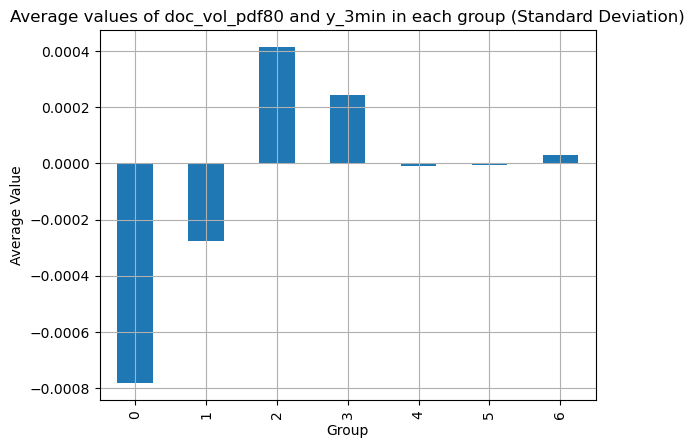

    group_std  doc_vol_pdf80    y_3min
0   -∞ to -3σ      -0.316667 -0.000782
1  -3σ to -2σ      -0.232222 -0.000275
2   -2σ to -σ      -0.112907  0.000414
3    -σ to +σ       0.040457  0.000245
4   +σ to +2σ       0.138563 -0.000010
5  +2σ to +3σ       0.220782 -0.000006
6   +3σ to +∞       0.339485  0.000030


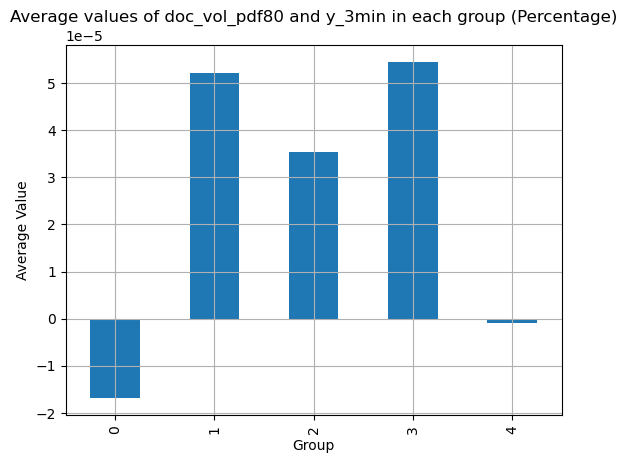

  group_percent  doc_vol_pdf80        y_3min
0         0-20%       0.189938 -1.687346e-05
1        20-40%       0.275476  5.214866e-05
2        40-60%       0.320808  3.540014e-05
3        60-80%       0.359651  5.450768e-05
4       80-100%       0.417654 -8.566020e-07


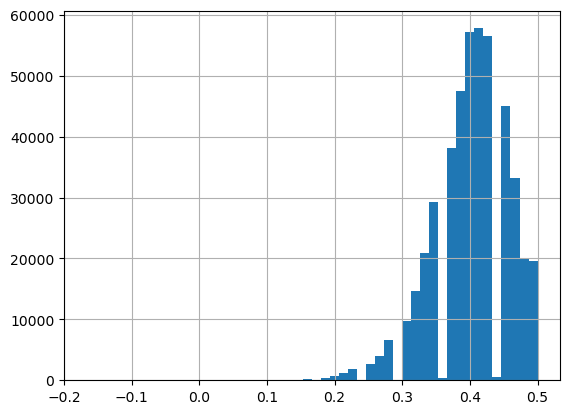

-0.16666666666666669 0.4026711263226761 0.5
    group_std  doc_vol_pdf90      ym_3
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000 -0.000238
3    -σ to +σ       0.011429  0.000103
4   +σ to +2σ       0.092694  0.000030
5  +2σ to +3σ       0.151860  0.000072
6   +3σ to +∞       0.402460  0.000001


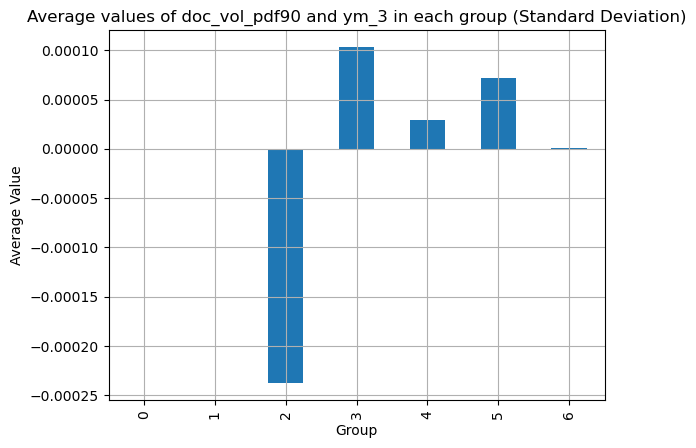

    group_std  doc_vol_pdf90      ym_3
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000 -0.000238
3    -σ to +σ       0.011429  0.000103
4   +σ to +2σ       0.092694  0.000030
5  +2σ to +3σ       0.151860  0.000072
6   +3σ to +∞       0.402460  0.000001


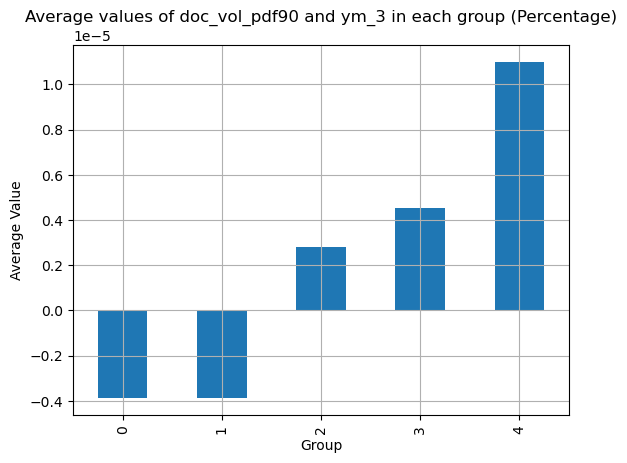

  group_percent  doc_vol_pdf90      ym_3
0         0-20%       0.328135 -0.000004
1        20-40%       0.388052 -0.000004
2        40-60%       0.417000  0.000003
3        60-80%       0.444188  0.000005
4       80-100%       0.477855  0.000011
    group_std  doc_vol_pdf90          ym_5
0   -∞ to -3σ            NaN           NaN
1  -3σ to -2σ            NaN           NaN
2   -2σ to -σ      -0.100000  2.376708e-04
3    -σ to +σ       0.011429  1.869466e-04
4   +σ to +2σ       0.092694  2.861099e-05
5  +2σ to +3σ       0.151860  1.305157e-04
6   +3σ to +∞       0.402460  8.167944e-07


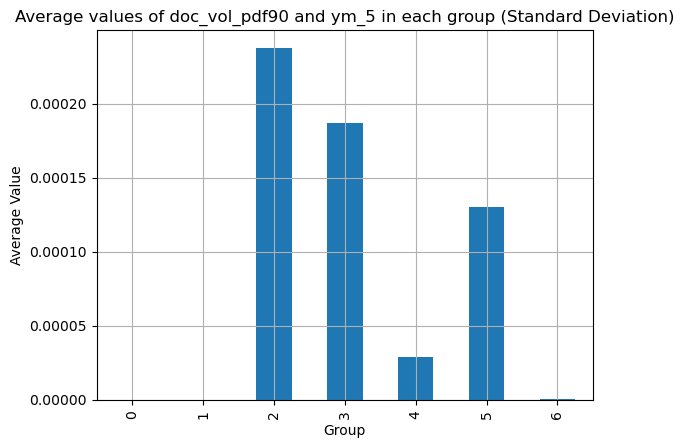

    group_std  doc_vol_pdf90          ym_5
0   -∞ to -3σ            NaN           NaN
1  -3σ to -2σ            NaN           NaN
2   -2σ to -σ      -0.100000  2.376708e-04
3    -σ to +σ       0.011429  1.869466e-04
4   +σ to +2σ       0.092694  2.861099e-05
5  +2σ to +3σ       0.151860  1.305157e-04
6   +3σ to +∞       0.402460  8.167944e-07


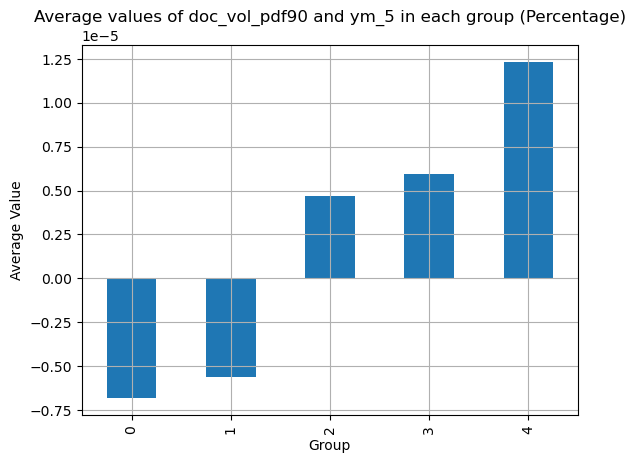

  group_percent  doc_vol_pdf90      ym_5
0         0-20%       0.328135 -0.000007
1        20-40%       0.388052 -0.000006
2        40-60%       0.417000  0.000005
3        60-80%       0.444188  0.000006
4       80-100%       0.477855  0.000012
    group_std  doc_vol_pdf90     ym_10
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000  0.000119
3    -σ to +σ       0.011429  0.000262
4   +σ to +2σ       0.092694  0.000138
5  +2σ to +3σ       0.151860  0.000218
6   +3σ to +∞       0.402460 -0.000003


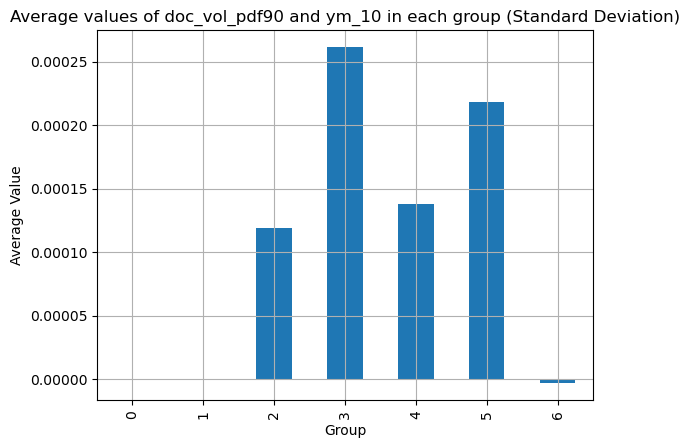

    group_std  doc_vol_pdf90     ym_10
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000  0.000119
3    -σ to +σ       0.011429  0.000262
4   +σ to +2σ       0.092694  0.000138
5  +2σ to +3σ       0.151860  0.000218
6   +3σ to +∞       0.402460 -0.000003


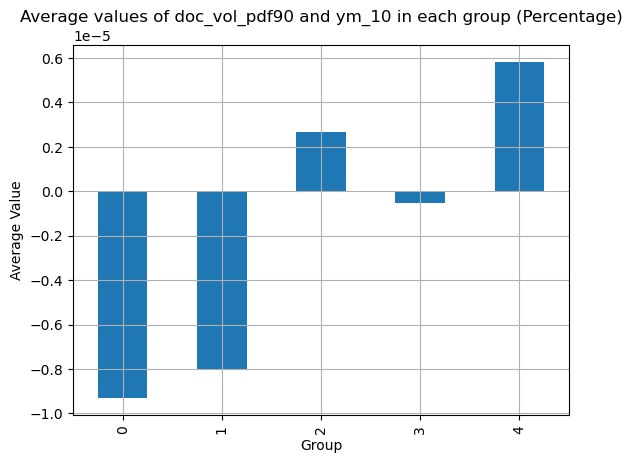

  group_percent  doc_vol_pdf90         ym_10
0         0-20%       0.328135 -9.309013e-06
1        20-40%       0.388052 -8.000789e-06
2        40-60%       0.417000  2.658632e-06
3        60-80%       0.444188 -5.327947e-07
4       80-100%       0.477855  5.816488e-06
    group_std  doc_vol_pdf90    y_1min
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000  0.000119
3    -σ to +σ       0.011429  0.000281
4   +σ to +2σ       0.092694  0.000095
5  +2σ to +3σ       0.151860  0.000200
6   +3σ to +∞       0.402460  0.000008


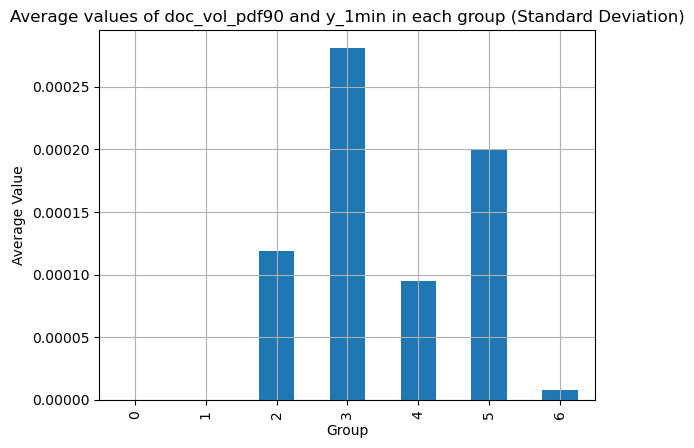

    group_std  doc_vol_pdf90    y_1min
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000  0.000119
3    -σ to +σ       0.011429  0.000281
4   +σ to +2σ       0.092694  0.000095
5  +2σ to +3σ       0.151860  0.000200
6   +3σ to +∞       0.402460  0.000008


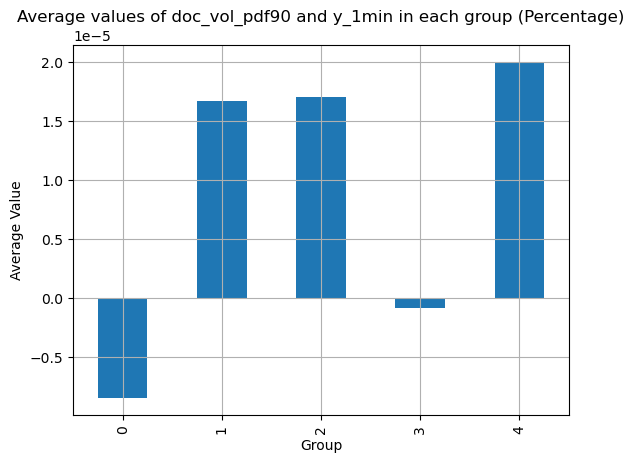

  group_percent  doc_vol_pdf90        y_1min
0         0-20%       0.328135 -8.497052e-06
1        20-40%       0.388052  1.670068e-05
2        40-60%       0.417000  1.708029e-05
3        60-80%       0.444188 -8.822884e-07
4       80-100%       0.477855  2.003422e-05
    group_std  doc_vol_pdf90    y_3min
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000  0.001664
3    -σ to +σ       0.011429 -0.000046
4   +σ to +2σ       0.092694  0.000329
5  +2σ to +3σ       0.151860  0.000597
6   +3σ to +∞       0.402460  0.000024


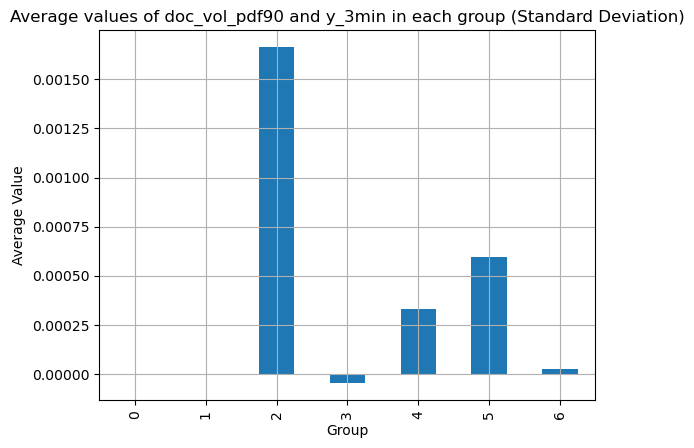

    group_std  doc_vol_pdf90    y_3min
0   -∞ to -3σ            NaN       NaN
1  -3σ to -2σ            NaN       NaN
2   -2σ to -σ      -0.100000  0.001664
3    -σ to +σ       0.011429 -0.000046
4   +σ to +2σ       0.092694  0.000329
5  +2σ to +3σ       0.151860  0.000597
6   +3σ to +∞       0.402460  0.000024


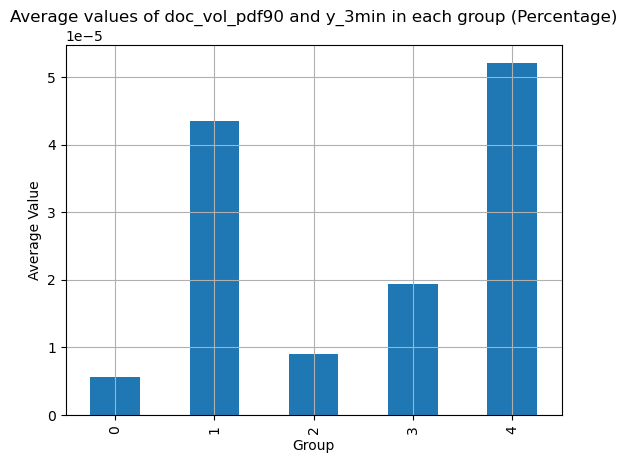

  group_percent  doc_vol_pdf90    y_3min
0         0-20%       0.328135  0.000006
1        20-40%       0.388052  0.000044
2        40-60%       0.417000  0.000009
3        60-80%       0.444188  0.000019
4       80-100%       0.477855  0.000052


In [27]:
# 回望 60 分位数 80 
assess_doc_vol_pdf_percent(data_extract, 60, 10, ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min'], True)
# 回望 60 分位数 80 
assess_doc_vol_pdf_percent(data_extract, 60, 20, ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min'], True)
# 回望 60 分位数 80 
assess_doc_vol_pdf_percent(data_extract, 60, 80, ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min'], True)
# 回望 60 分位数 80 
assess_doc_vol_pdf_percent(data_extract, 60, 90, ['ym_3', 'ym_5', 'ym_10', 'y_1min', 'y_3min'], True)

## 7.3日测评结果

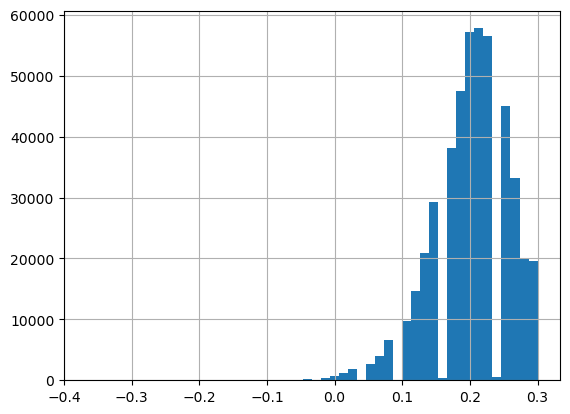

-0.36666666666666664 0.2026711263226762 0.30000000000000004
    group_std  doc_vol_pdf90    y_1min
0   -∞ to -3σ      -0.211594  0.000277
1  -3σ to -2σ      -0.133730  0.000363
2   -2σ to -σ      -0.078832  0.000196
3    -σ to +σ       0.025940  0.000027
4   +σ to +2σ       0.091888  0.000041
5  +2σ to +3σ       0.146351 -0.000028
6   +3σ to +∞       0.226013  0.000013


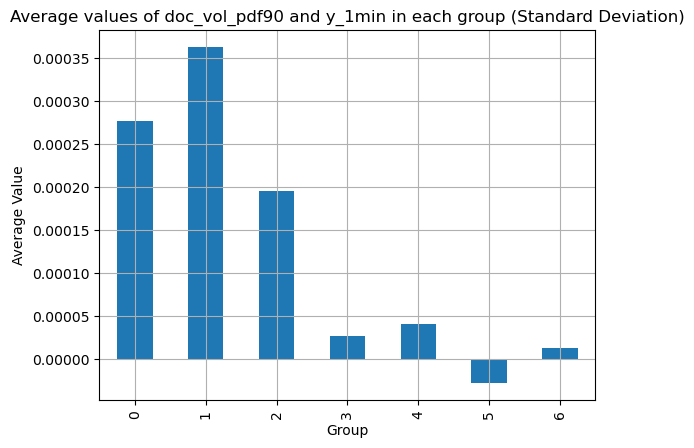

    group_std  doc_vol_pdf90    y_1min
0   -∞ to -3σ      -0.211594  0.000277
1  -3σ to -2σ      -0.133730  0.000363
2   -2σ to -σ      -0.078832  0.000196
3    -σ to +σ       0.025940  0.000027
4   +σ to +2σ       0.091888  0.000041
5  +2σ to +3σ       0.146351 -0.000028
6   +3σ to +∞       0.226013  0.000013


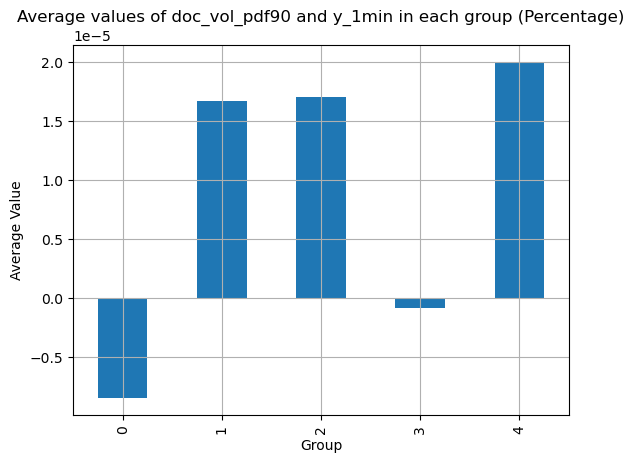

  group_percent  doc_vol_pdf90        y_1min
0         0-20%       0.128135 -8.497052e-06
1        20-40%       0.188052  1.670068e-05
2        40-60%       0.217000  1.708029e-05
3        60-80%       0.244188 -8.822884e-07
4       80-100%       0.277855  2.003422e-05


In [22]:
print_factor_dist(data2, 'doc_vol_pdf90')
print_grouped_results(data2, 'doc_vol_pdf90', 'y_1min')

In [24]:
def doc_vol_pdf_percent(df, timeperiod, percent):
    df['return'] = df['mid_px'].pct_change(periods=timeperiod)
    
    # 填充前面的部分
    result_list = [np.nan] * (timeperiod - 1)
    
    # 滚动计算每一行的分位数
    for i in range(timeperiod-1, len(df)):
        
        rolling_window = df.iloc[i-timeperiod+1:i+1]
        rolling_returns = rolling_window['return'].dropna()
        
        if rolling_returns.empty:
            result_list.append(np.nan)
            continue
        
        # 创建一个DataFrame来存储收益率和对应的tick_amt
        temp_df = pd.DataFrame({
            'return': rolling_returns,
            'tick_amt': rolling_window['tick_amt']
        })
        
        # 对收益率进行排序
        temp_df = temp_df.sort_values(by='return')

        # 合并大小相同的收益率，求和tick_amt
        merged_df = temp_df.groupby('return', as_index=False)['tick_amt'].sum()
        
        # 计算累积成交量
        merged_df['cumsum_amt'] = merged_df['tick_amt'].cumsum()
        
        # 找到60%的那一行
        total_amount = merged_df['tick_amt'].sum()
        threshold_amount = percent/100 * total_amount
        pdf60_return = merged_df.loc[merged_df['cumsum_amt'] >= threshold_amount, 'return'].iloc[0]
        
        # 计算这个收益率在window中的分位数
        p = (rolling_returns <= pdf60_return).mean()
        p -= 0.3
        
        result_list.append(p)
    
    return result_list

In [25]:
data1 = insert_doc_vol_pdf_percent(data, 100, 10)

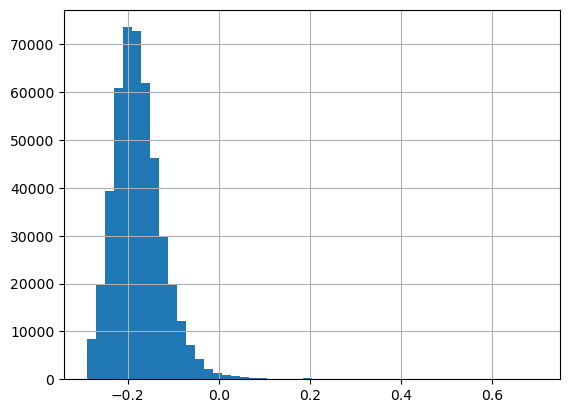

-0.29 -0.18048893902059351 0.7
    group_std  doc_vol_pdf10      ym_3
0   -∞ to -3σ      -0.212985 -0.000002
1  -3σ to -2σ      -0.154702  0.000003
2   -2σ to -σ      -0.100920  0.000012
3    -σ to +σ      -0.028865  0.000017
4   +σ to +2σ       0.086381  0.000055
5  +2σ to +3σ       0.150785  0.000035
6   +3σ to +∞       0.376460 -0.000033


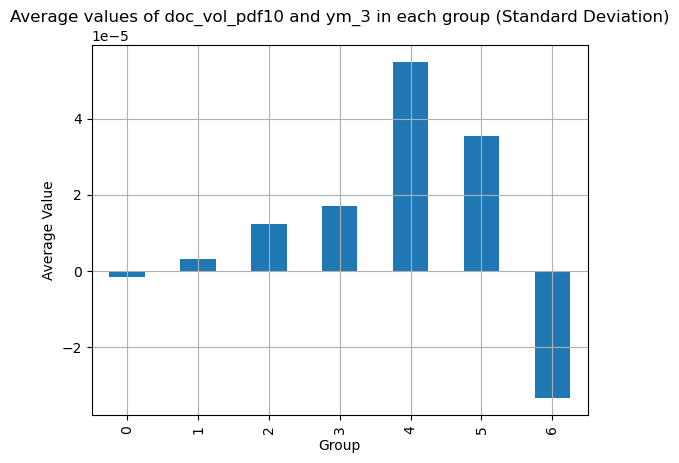

    group_std  doc_vol_pdf10      ym_3
0   -∞ to -3σ      -0.212985 -0.000002
1  -3σ to -2σ      -0.154702  0.000003
2   -2σ to -σ      -0.100920  0.000012
3    -σ to +σ      -0.028865  0.000017
4   +σ to +2σ       0.086381  0.000055
5  +2σ to +3σ       0.150785  0.000035
6   +3σ to +∞       0.376460 -0.000033


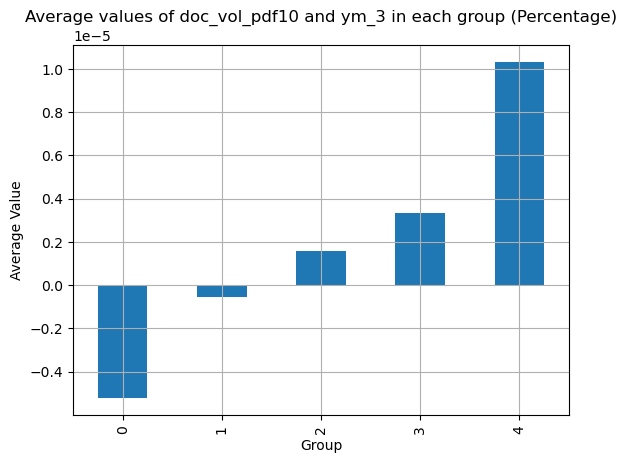

  group_percent  doc_vol_pdf10          ym_3
0         0-20%      -0.242841 -5.220661e-06
1        20-40%      -0.206778 -5.456478e-07
2        40-60%      -0.182066  1.566267e-06
3        60-80%      -0.154191  3.345189e-06
4       80-100%      -0.094760  1.031501e-05


In [26]:
data2 = data1.dropna(subset=['doc_vol_pdf10'])
print_factor_dist(data2, 'doc_vol_pdf10')
print_grouped_results(data2, 'doc_vol_pdf10', 'ym_3')